# <ins>Song Lyrics Through the Years</ins>

# Natural Language Processing and Data Exploration

- In this notebook, I engineer features based on lyrical form, process the text using natural language processing techniques, and explore my data.
- I also create charts and word clouds based on this exploration.

## Table of contents

1. [Introduction](#Introduction)
2. [The problem domain](#The-problem-domain)
3. [Required libraries](#Required-libraries)
4. [Step 1: Answering some initial questions](#Step-1:-Answering-some-initial-questions)
5. [Step 2: Preparing the data](#Step-2:-Preparing-the-data)

    - [Create movements](#Create-movements)
    
    
6. [Step 3: Feature engineering and exploratory data analysis](#Step-3:-Feature-engineering-and-exploratory-data-analysis)

    - [Number of words](#Number-of-words)
        - [Chart](#Number-of-words----Boxplot)
    - [Sentiment, polarity](#Sentiment,-polarity)
        - [Chart 1](#Polarity-score----Boxplot) | [Chart 2](#Polarity----Stacked-bar-chart)
    - [Sentiment, subjectivity](#Sentiment,-subjectivity)
        - [Chart](#Subjectivity-score----Boxplot)
    - [Number of end rhymes](#Number-of-end-rhymes)
        - [Chart](#Number-of-end-rhymes----Boxplot)
    - [Ratio of end rhymes](#Ratio-of-end-rhymes)
        - [Chart](#Ratio-of-end-rhymes----Boxplot)
    - [End rhymes, categorical](#End-rhymes,-categorical)
        - [Chart](#End-rhymes----Stacked-bar-chart)
    - [Syllables per word](#Syllables-per-word)
        - [Chart](#Syllables-per-word----Boxplot)
    - [Lexical richness](#Lexical-richness)
        - [Chart](#Lexical-richness----Boxplot)
    - [Experiments](#Experiments)
    
    
7. [Step 4: Natural language processing](#Step-4:-Natural-language-processing)

    - [Total word counts and vocabulary](#Total-word-counts-and-vocabulary)
    - [Most frequent words](#Most-frequent-words)
        - [Chart 1](#Most-frequent-words-overall) | [Chart 2](#Most-frequent-words-by-genre) | [Chart3](#Word-cloud-overall) | [Chart 4](#Word-clouds-by-genre)
    

8. [Preliminary conclusions](#Preliminary-conclusions)
9. [Save/Load DataFrame](#💾-Save/Load-DataFrame)
10. [Next notebook: Modeling](#Next-notebook:-Modeling)

## Introduction

[[go back to the top](#Song-Lyrics-Through-the-Years)]

After [scraping](01_webscraping.ipynb) [Top 40 Weekly](https://top40weekly.com/) and [Genius](https://genius.com) for year-labeled song lyrics and [cleaning](02_data_cleaning.ipynb), I will use natural language processing (NLP) techniques to analyze song lyrics across decades. Since decades tend to kind of "bleed into each other", I anticipate a less-than-stellar classification model, but am excited by the prospect of using clustering techniques to create labels that aren't necessarily confined to a certain decade.

Through text processing, exploratory data analysis, and feature engineering, I will look for insights into how song structure, word usage, lexical richness, and sentiment relate to the time in which a song became popular.

I will then create predictive models that classify songs into one of six decades: *1960s*, *1970s*, *1980s*, *1990s*, *2000s*, or *2010s*. This will help provide further insight and confirm my findings during EDA. *(To skip to the modeling notebook, click [here](04_modeling.ipynb))*.

The ultimate goal is to create a text generator that can write in the style of each decade.

## The problem domain

[[go back to the top](#Song-Lyrics-Through-the-Years)]

Within written media, poetry is often regarded as enigmatic, frivolous, or too niche. As a result, poems (even by established poets) are often overlooked by larger publishers and literature-focused websites alike. (The anti-capitalist nature of poetry may play a role here as well). There are services for rating and recommending entire books (including poetry collections, to be fair) like GoodReads, Amazon, or Bookish, but to my knowledge, there aren't any sites or services that recommend poems on an individual level.

With this in mind, I wondered how poem recommendation may even work. One often finds a genre or two that they like and searches that out, but there must be elements of poetry that transcend genre. If there are, machine learning seems like a perfect tool to use to find them. As a poet and writer, I am interested in creating something that will allow me to discover genres and movements that I may have previously ignored. I can do this by using poems I already know and enjoy to find similar poems from genres I may not know as well.

## Required libraries

[[go back to the top](#Song-Lyrics-Through-the-Years)]

This notebook uses several Python packages that come standard with the Anaconda Python distribution. Libraries within this category that I'll be using are:

- **numpy**: Provides a fast numerical array structure and helper functions.
- **pandas**: Provides a DataFrame structure to store data in memory and work with it easily and efficiently.
- **matplotlib**: Basic plotting library in Python; most other Python plotting libraries are built on top of it.
- **seaborn**: Advanced statistical plotting library.
- **scikit-learn**: The essential Machine Learning package in Python.
- **scipy**: The essential statistical analysis package in Python.
- **collections**: A package with specialized and higher-performance data structures.
- **warnings**: A helpful package to ignore warnings that unnecessarily clutter the notebook.
- **watermark**: A Jupyter Notebook extension for printing timestamps, version numbers, and hardware information.

This notebook also uses some additional packages that you may have to install:

- **nltk**: The essential natural language processing package.
- **textblob**: A supplementary package to enhance the nltk package.
- **vaderSentiment**: A sentiment analysis tool based on human-compiled data.
- **wordcloud**: A library focused on plotting word frequencies.
- **pickle**: Package to save a file as a byte stream.
- **gzip**: Package to compress/unpack files.

Finally, included within the repository, and necessary to run this workbook, is:
- **[process_explore](functions/process_explore.py)**: Custom functions that I built for this project.

Required within the functions file, are:
- **itertools**: An package aiding in advanced iteration techniques.
- **regex**: The essential string matching and capturing package.
- **string**: A package with string-specific operations and characters.
- **pronouncing**: A package utilizing the CMU Pronouncing Dictionary that can break language down by syllable, rhyme, and meter.

Run the cell below to import all of the necessary packages.

In [1]:
# custom functions for this project
from functions.process_explore import *

# dataframe packages
import pandas as pd
import numpy as np

# graphing packages
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('ticks')
from wordcloud import WordCloud

# statistics packages
import scipy.stats as stats

# text processing
from nltk.corpus import stopwords
from nltk.probability import FreqDist 
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# miscellany
from collections import Counter
import time
import gzip
import pickle

# reload functions/libraries when edited
%load_ext autoreload
%autoreload 2

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# increase column width of dataframe
pd.set_option('max_colwidth', 150)

# Step 1: Answering some initial questions

[[go back to the top](#Song-Lyrics-Through-the-Years)]

**Where does the data come from?**

> The data is comprised of 4,307 poems from [PoetryFoundation.org](https://www.poetryfoundation.org/), after dropping some older genres of poetry (*Middle English*, *Renaissance*, and *Augustan*), as well as some lesser-known, allegedly white supremacist genres (*Georgian* and *Fugitive*).

> The data came in both text format and as scanned images, from which I was able to capture the text using PyTesseract.

> I scraped the data myself, using custom functions that can be found in this [file](functions_webscraping.py). Refer to the webscraping [notebook](01_webscraping.ipynb) for a closer look at the scraping (and rescraping) process. The original count of scraped poems was 5,197, though this did include some duplicate scrapes.

> Refer to the data cleaning [notebook](02_data_cleaning.ipynb) for a detailed guide on the cleaning process, which included dropping duplicates and more rescraping.

**What do the variables mean in actual language?**

> The poem itself is the main variable--I scraped the poem as both a list of lines, as well as an endline-joined (\n) string. Also scraped were the poem's URL, for reference if necessary, the name of the poet, title of the poem, and the target variable, genre. 

> Other variables I look at within this notebook are ones that I engineered. They are listed below:
> - <ins>Number of lines</ins>
    - The standard measure of the length of a poem. Prose poems, however, do complicate this as they are often only one line.
    <br/><br/>
> - <ins>Average number of words per line</ins>
    - A measure of the length of each line within a poem, which can be fairly telling of time period, as more contemporary poems tend to have fewer words in a line. That said, there is often a back and forth across time as art movements continously reject past movements.
    <br/><br/>
> - <ins>Average number of syllables per word</ins>
    - A proxy for complexity of language. More complex language will use words with more syllables on average than simpler language.
    <br/><br/>
> - <ins>Number and usage of end rhymes</ins>
    - End rhymes occur when a word at the end of a line rhymes with another word at the end of a line. During EDA, I look at this as both a continuous and categorical variable.
    <br/><br/>
> - <ins>Sentiment (polarity and subjectivity)</ins>
    - Whether a poem uses positive, negative, or neutral language (polarity) and whether a poem uses more opinion-based language (subjective) or fact-based language (objective).
    <br/><br/>
> - <ins>Lexical richness</ins>
    - A measure of the number of unique words within a poem. A lower value indicates a more repetitious poem, whereas a value of 1.0 would indicate that each word is used only once.

**What is the target variable?**

> The target variable is the genre of the poem, which was provided by PoetryFoundation.org. In order to limit the number of classes for my classification models, I created umbrella movements using my domain knowledge of poetry alongside some research. The list of genres (and their umbrella movement) is below:
> - Beat (Metropolitan)
> - Black Arts Movement (Metropolitan)
> - Black Mountain (Avant-Garde)
> - Confessional (Metropolitan)
> - Harlem Renaissance (Metropolitan)
> - Imagist (Avant-Garde)
> - Language Poetry (Avant-Garde)
> - Modern (Modern)
> - New York School (Metropolitan)
> - New York School, 2nd Generation (Metropolitan)
> - Objectivist (Avant-Garde)
> - Romantic (Pre-1900)
> - Victorian (Pre-1900)

> It's worth noting that the umbrella movements are not perfect but are a decent direction to go with. Modern is a very overrepresented genre and is its own category. Pre-1900 poetries are self-explanatory. There is definitely some overlap between Modern, Metropolitan, and Avant-Garde poetries, but these are arguably correct delineations.
    
**What is the range, scale, or distribution of each variable?**

> These are detailed within each section of [Step 3](#Step-3:-Feature-engineering-and-exploratory-data-analysis).
    
**What elements of the data will or will not address the business question?**

> Poem URLS were only used during the rescraping process. Also, the name of the poet will not (and cannot, scientifically) be used to predict the poetic movement of a poem. Though I do not use it in this project, the name of the poet could be a great variable to look into during EDA. 

> The main variables, as with most NLP projects, will be the individual word vectors, i.e. the language used in each poem.
    
**Are there any issues related to data permissions, copyright, ethical issues, confidential information, etc.?**

> Using this data is most assuredly not allowed under their [terms of service](https://www.poetryfoundation.org/foundation/terms-of-service). While there may be data permissions and copyright issues here, I do not think there is anything ethically wrong with the project, as I am not publishing any of the poetry scraped from the site. In fact the poetry generator I create using this project links to their website and would only increase the traffic their site receives. Furthermore, I am definitely not making any money off of the project, and I believe the project is of scientific value.
    
**Are there any interesting aspects or anomalies in the data such as outliers or missing data?**

> One notable aspect of the data is that the OCR (optical character recognition) or image-to-text tool, PyTesseract, is imperfect so some of the individual words and lines may have been scraped incorrectly. I also had some difficulty  consistently scraping multiple page poems (since PyTesseract sometimes does not grab page numbers), again due to this imperfection. As a result, some poems are truncated versions of themselves, though I do believe a lot of this was corrected during my arduous rescraping process.

> After the data cleaning process in the [previous notebook](02_data_cleaning.ipynb), there shouldn't be any missing data.
    
**What additional data would be really helpful to your analysis?**

> An accurate year of publication (or better yet, of writing) would be really helpful. I had originally scraped the year from the site, but it was inconsistent and often reflected the year it was published in the magazine, rather than the actual year of the poem. Ideally, with this information, I could spot trends across time regarding many of my engineered features, as well as the language itself.

> It may be worth, in the future, considering analyzing the role of gender among the variables. Potentially interesting, even if they end up being fairly equal.

**Did you specify the type of data analytic question (e.g. exploration, association causality) before touching the data?**

> This will be an NLP, exploration, feature engineering, classification, and recommendation system project. To look at the classification portion of the project, refer to the [modeling notebook](04_modeling.ipynb). To look at the classification portion of the project, refer to the [recommendation system notebook](05_recommendation_system.ipynb). 

**Did you define the metric for success before beginning?**

> There is a small amount of class imbalance after creating the umbrella movements, so I will still use F1 score over accuracy, as the F1 score is the most complete measure of false predictions and doesn't overemphasize models that overpredict one class.

# Step 2: Preparing the data

[[go back to the top](#Song-Lyrics-Through-the-Years)]

- Import the cleaned data and take a look.

#### 💾 Load DataFrame

In [2]:
with gzip.open('data/lyrics_df_clean.pkl', 'rb') as hello:
    df = pickle.load(hello)
    
df.shape

(4682, 7)

In [3]:
df.head()

year decade                             title          artist  \
0  1960  1960s     the village of st. bernadette   andy williams   
1  1960  1960s  in my little corner of the world    anita bryant   
2  1960  1960s                       paper roses    anita bryant   
3  1960  1960s                         o dio mio         annette   
4  1960  1960s               wonderland by night  bert kaempfert   

                                                                                                                                                  lyrics  \
0  i've traveled far, the land and the sea\nbeautiful places i happened to be\none little town i'll never forget\nis lourdes, the village of st. bern...   
1  oh, come along with me\nto my little corner of the world\nand dream a little dream\nin my little corner of the world\n\ntonight, my love\nwe'll sh...   
2  i realize the way your eyes deceived me\nwith tender looks that i mistook for love\nso take away the flowers that you gave me\nand send the kind t...   
3  e un giorno lui mi disse: "nei tuoi occhi vedo fame\nnon vedo rabbia, figlio, no\nma voglia di lottare."\ndivisi il cibo nel mio piatto col rivale...   
4  stars hang suspended\nabove a floating yellow moon\ntwo hearts were blended\nwhile angels sang a lover's tune\n\nand so we kissed\nnot knowing if ...   

                                                                                                                                            lyrics_lined  \
0  [i've traveled far, the land and the sea, beautiful places i happened to be, one little town i'll never forget, is lourdes, the village of st. ber...   
1  [oh, come along with me, to my little corner of the world, and dream a little dream, in my little corner of the world, tonight, my love, we'll sha...   
2  [i realize the way your eyes deceived me, with tender looks that i mistook for love, so take away the flowers that you gave me, and send the kind ...   
3  [e un giorno lui mi disse: "nei tuoi occhi vedo fame, non vedo rabbia, figlio, no, ma voglia di lottare.", divisi il cibo nel mio piatto col rival...   
4  [stars hang suspended, above a floating yellow moon, two hearts were blended, while angels sang a lover's tune, and so we kissed, not knowing if o...   

                                                                                                                                        lyrics_no_artist  
0  i've traveled far, the land and the sea\nbeautiful places i happened to be\none little town i'll never forget\nis lourdes, the village of st. bern...  
1  oh, come along with me\nto my little corner of the world\nand dream a little dream\nin my little corner of the world\n\ntonight, my love\nwe'll sh...  
2  i realize the way your eyes deceived me\nwith tender looks that i mistook for love\nso take away the flowers that you gave me\nand send the kind t...  
3  e un giorno lui mi disse: "nei tuoi occhi vedo fame\nnon vedo rabbia, figlio, no\nma voglia di lottare."\ndivisi il cibo nel mio piatto col rivale...  
4  stars hang suspended\nabove a floating yellow moon\ntwo hearts were blended\nwhile angels sang a lover's tune\n\nand so we kissed\nnot knowing if ...

In [4]:
# look at the distribution of songs
df.decade.value_counts()

1960s    1026
1980s     954
1970s     946
1990s     687
2000s     578
2010s     491
Name: decade, dtype: int64

In [5]:
# as a percentage
df.decade.value_counts(normalize=True)

1960s    0.219137
1980s    0.203759
1970s    0.202050
1990s    0.146732
2000s    0.123452
2010s    0.104870
Name: decade, dtype: float64

- There is some class imbalance here that I will have to account for when I get to modeling.
- The Billboard Top 10 in the 1960s through 1980s seems to have been much more volatile than the 1990s through 2010s. Songs in the latter decades must stay within the Top 10 for much longer compared to the former decades.

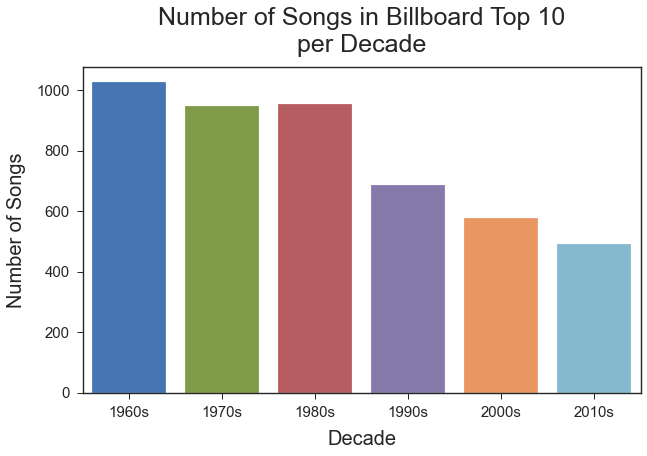

In [6]:
# graph number of songs per decade
plt.figure(figsize=(10,6))
sns.barplot(x=df.decade.value_counts().sort_index().index, y=df.decade.value_counts().sort_index())
plt.title('Number of Songs in Billboard Top 10\nper Decade', fontsize=25, pad=15)
plt.xlabel('Decade', fontsize=20, labelpad=10)
plt.ylabel('Number of Songs', fontsize=20, labelpad=10)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

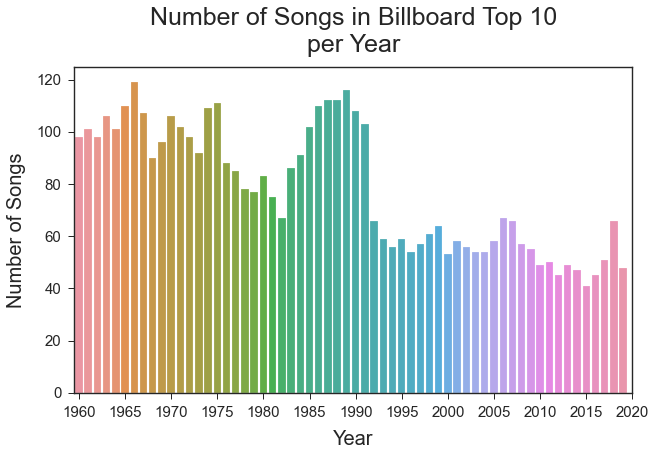

In [7]:
# graph number of songs per year
plt.figure(figsize=(10,6))
sns.barplot(x=df.year.value_counts().sort_index().index, y=df.year.value_counts().sort_index())
plt.title('Number of Songs in Billboard Top 10\nper Year', fontsize=25, pad=15)
plt.xlabel('Year', fontsize=20, labelpad=10)
plt.ylabel('Number of Songs', fontsize=20, labelpad=10)
plt.xticks(ticks=range(0,61,5), labels=range(1960,2021,5), fontsize=15)
plt.yticks(fontsize=15)
plt.show()

# Step 3: Feature engineering and exploratory data analysis

[[go back to the top](#Song-Lyrics-Through-the-Years)]

- Engineer numerical features based on aspects of a song, including but not limited to word count, usage of end rhymes (?), and lexical richness.
- Explore these features as a whole and across each decade.
- Create visualizations to better understand the differences and similarities between movements.

### Number of words

[[go back to the top](#Song-Lyrics-Through-the-Years)]

- Since the data is user-generated and doesn't have consistent form/structure, the number of words is the best measure for its length. I'd like to explore if any decades tend to have wordier or more concise songs than the rest.
- I'll count words using the `lyrics` column.

In [8]:
# create column using custom word counting function
df['num_words'] = df.lyrics.apply(word_counter)

In [9]:
# number of words stats as a whole
df.num_words.describe()

count    4682.000000
mean      326.290901
std       174.813251
min        14.000000
25%       206.000000
50%       283.000000
75%       397.000000
max      1439.000000
Name: num_words, dtype: float64

In [10]:
# number of words stats by decade
df.groupby('decade').num_words.describe().T

decade        1960s        1970s        1980s        1990s        2000s  \
count   1026.000000   946.000000   954.000000   687.000000   578.000000   
mean     209.321637   254.440803   293.741090   390.275109   512.897924   
std       94.148693   110.411367   109.450277   174.246060   198.080201   
min       14.000000    30.000000    66.000000   107.000000    80.000000   
25%      152.000000   187.000000   220.000000   268.000000   343.750000   
50%      196.000000   239.500000   280.000000   344.000000   497.000000   
75%      252.000000   300.000000   345.000000   478.500000   654.000000   
max     1417.000000  1174.000000  1192.000000  1372.000000  1075.000000   

decade        2010s  
count    491.000000  
mean     463.189409  
std      177.780600  
min       97.000000  
25%      343.500000  
50%      433.000000  
75%      559.000000  
max     1439.000000

#### Statistical analysis

In [11]:
# one-way ANOVA
stats.f_oneway(
    df[df.decade == '1960s'].num_words,
    df[df.decade == '1970s'].num_words,
    df[df.decade == '1980s'].num_words,
    df[df.decade == '1990s'].num_words,
    df[df.decade == '2000s'].num_words,
    df[df.decade == '2010s'].num_words
)

F_onewayResult(statistic=535.2973230841479, pvalue=0.0)

- At least one statistically significant difference is present.
- I'll now perform two-sided t-tests on all possible combinations within these four categories.

In [12]:
# list of series on which to perform two-sided t-tests
num_words_list = [
    df[df.decade == dec].num_words for dec in df.decade.unique()
]

In [13]:
# test each combination
two_way_tests(num_words_list, df.decade.unique())

{('1960s',
  '1970s'): Ttest_indResult(statistic=-9.787362206416626, pvalue=4.03606420477496e-22),
 ('1960s',
  '1980s'): Ttest_indResult(statistic=-18.436301372899408, pvalue=3.622761126662785e-70),
 ('1960s',
  '1990s'): Ttest_indResult(statistic=-27.760690380246672, pvalue=2.4132502452657526e-140),
 ('1960s',
  '2000s'): Ttest_indResult(statistic=-41.47977120305345, pvalue=4.7416309965272995e-256),
 ('1960s',
  '2010s'): Ttest_indResult(statistic=-36.32544680027296, pvalue=2.424341999244216e-208),
 ('1970s',
  '1980s'): Ttest_indResult(statistic=-7.791535451827572, pvalue=1.0816237876207186e-14),
 ('1970s',
  '1990s'): Ttest_indResult(statistic=-19.24161614889776, pvalue=1.6130793299574412e-74),
 ('1970s',
  '2000s'): Ttest_indResult(statistic=-32.67825503743961, pvalue=6.544336141959194e-178),
 ('1970s',
  '2010s'): Ttest_indResult(statistic=-27.357003884893327, pvalue=5.8565729313419055e-133),
 ('1980s',
  '1990s'): Ttest_indResult(statistic=-13.754367665784253, pvalue=8.077894713

- All tests produced statistically significant results. 
- A boxplot may paint a better picture.

### Number of words -- Boxplot

[[go back to the top](#Song-Lyrics-Through-the-Years)]

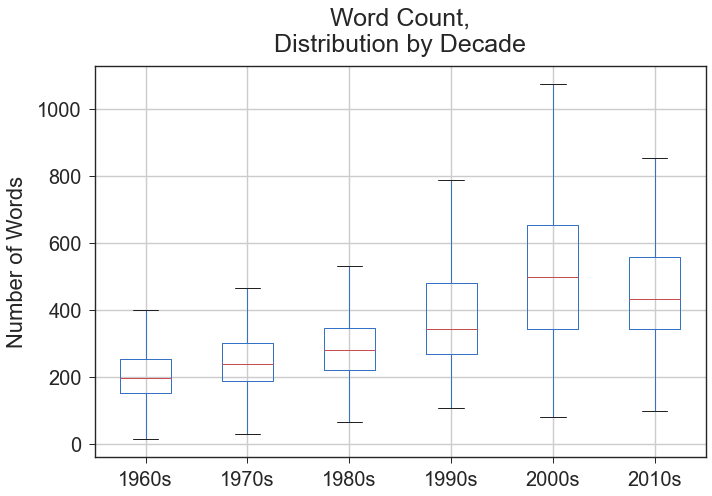

In [14]:
# plot the graph
df.boxplot('num_words', 'decade', 
           showfliers=False, figsize=(10,7))

# prettify the graph
plt.title('Word Count,\nDistribution by Decade', 
          fontsize=25, pad=15)
plt.suptitle('')
plt.xlabel('')
plt.ylabel('Number of Words', fontsize=22, labelpad=10)

# plot the labels
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# prepare to save and display
plt.tight_layout()
# # uncomment to save
# plt.savefig('charts/num_words_boxplot.png', 
#             bbox_inches='tight', transparent=True)

plt.show()

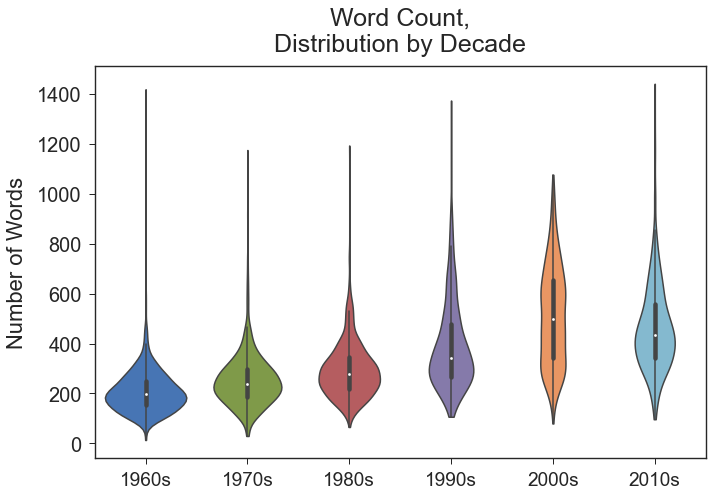

In [15]:
plt.figure(figsize=(10,7))

# plot the graph
sns.violinplot('decade', 'num_words', data=df, showextrema=False, 
               cut=0
              )

# prettify the graph
plt.title('Word Count,\nDistribution by Decade', 
          fontsize=25, pad=15)
plt.suptitle('')
plt.xlabel('')
plt.ylabel('Number of Words', fontsize=22, labelpad=10)

# plot the labels
plt.xticks(fontsize=19)
plt.yticks(fontsize=20)

# prepare to save and display
plt.tight_layout()
# # uncomment to save
# plt.savefig('charts/num_lines_boxplot.png', 
#             bbox_inches='tight', transparent=True)

plt.show()

- Some interesting results. Again, 1960s thru 1980s look fairly similar; they are mostly normally distributed although there is a notable increase in wordiness with each passing decade.
- The 1990s appears to skew toward extra wordy songs, with a very wide range.
- The 2000s appears bimodal with a fairly equal number of shorter songs and wordy songs. Again, a very wide range.
- The 2010s is fairly normal, although the range is wider than in those earlier decades.
- All decades other than the 2000s have notable outliers.

### Sentiment, polarity

[[go back to the top](#Song-Lyrics-Through-the-Years)]

- I wonder whether any decades tend to be more positive, negative, or neutral.
- I'll use VADER to obtain a polarity score, which I can use as a continuous variable, as well as convert to a categorical variable.

In [16]:
%%time

# instantiate VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# create a column with the compound polarity score, passing in the raw poem
df['sentiment_polarity_score'] = df['lyrics'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

CPU times: user 47.2 s, sys: 115 ms, total: 47.3 s
Wall time: 47.6 s


In [17]:
# convert to categorical variable
conditions = [
    df.sentiment_polarity_score >= .05,
    df.sentiment_polarity_score <= -.05
]

choices = [
    'positive',
    'negative'
]

df['sentiment_polarity'] = np.select(conditions, 
                                     choices, 
                                     'neutral')

In [18]:
# polarity score stats as a whole
df.sentiment_polarity_score.describe()

count    4682.000000
mean        0.572197
std         0.728490
min        -0.999900
25%         0.626175
50%         0.980000
75%         0.995900
max         1.000000
Name: sentiment_polarity_score, dtype: float64

In [19]:
# polarity score stats by movement
df.groupby('decade').sentiment_polarity_score.describe().T

decade        1960s       1970s       1980s       1990s       2000s  \
count   1026.000000  946.000000  954.000000  687.000000  578.000000   
mean       0.608726    0.595362    0.607218    0.641387    0.483045   
std        0.668083    0.701687    0.701319    0.688778    0.812037   
min       -0.998500   -0.999700   -0.999900   -0.999700   -0.999700   
25%        0.624525    0.692425    0.751775    0.863550   -0.289850   
50%        0.971850    0.976950    0.980150    0.991300    0.986800   
75%        0.992450    0.995100    0.996400    0.997700    0.997375   
max        0.999900    0.999900    1.000000    0.999900    0.999900   

decade       2010s  
count   491.000000  
mean      0.391327  
std       0.856867  
min      -0.999900  
25%      -0.765750  
50%       0.977500  
75%       0.996200  
max       0.999900

#### Statistical analysis

In [20]:
# one-way ANOVA
stats.f_oneway(
    df[df.decade == '1960s'].sentiment_polarity_score,
    df[df.decade == '1970s'].sentiment_polarity_score,
    df[df.decade == '1980s'].sentiment_polarity_score,
    df[df.decade == '1990s'].sentiment_polarity_score,
    df[df.decade == '2000s'].sentiment_polarity_score,
    df[df.decade == '2010s'].sentiment_polarity_score
)

F_onewayResult(statistic=10.273077499481483, pvalue=8.243649179755263e-10)

- At least one statistically significant difference is present.
- I'll now perform two-sided t-tests on all possible combinations within these four categories.

In [21]:
# list of series on which to perform two-sided t-tests
sentiment_polarity_score_list = [
    df[df.decade == dec].sentiment_polarity_score for dec in df.decade.unique()
]

In [22]:
# test each combination
two_way_tests(sentiment_polarity_score_list, df.decade.unique())

{('1960s',
  '1970s'): Ttest_indResult(statistic=0.43320488599181567, pvalue=0.6649133557784602),
 ('1960s',
  '1980s'): Ttest_indResult(statistic=0.048990735227826265, pvalue=0.9609316253613149),
 ('1960s',
  '1990s'): Ttest_indResult(statistic=-0.979400240097046, pvalue=0.3275207168164467),
 ('1960s',
  '2000s'): Ttest_indResult(statistic=3.341354030681905, pvalue=0.00085288945369724),
 ('1960s',
  '2010s'): Ttest_indResult(statistic=5.393925805050055, pvalue=7.987498707673025e-08),
 ('1970s',
  '1980s'): Ttest_indResult(statistic=-0.3683551816488558, pvalue=0.7126494898290984),
 ('1970s',
  '1990s'): Ttest_indResult(statistic=-1.3186702454094041, pvalue=0.18746450646559717),
 ('1970s',
  '2000s'): Ttest_indResult(statistic=2.8539430489708533, pvalue=0.004376489344850671),
 ('1970s',
  '2010s'): Ttest_indResult(statistic=4.837789404718828, pvalue=1.4544238004419536e-06),
 ('1980s',
  '1990s'): Ttest_indResult(statistic=-0.9809687343417459, pvalue=0.3267529356275658),
 ('1980s',
  '20

- In terms of insignificance/significance, it looks like there are similarities between the 1960s, 1970s, and 1980s, as well as the 2000s and 2010s.

### Polarity score -- Boxplot

[[go back to the top](#Song-Lyrics-Through-the-Years)]

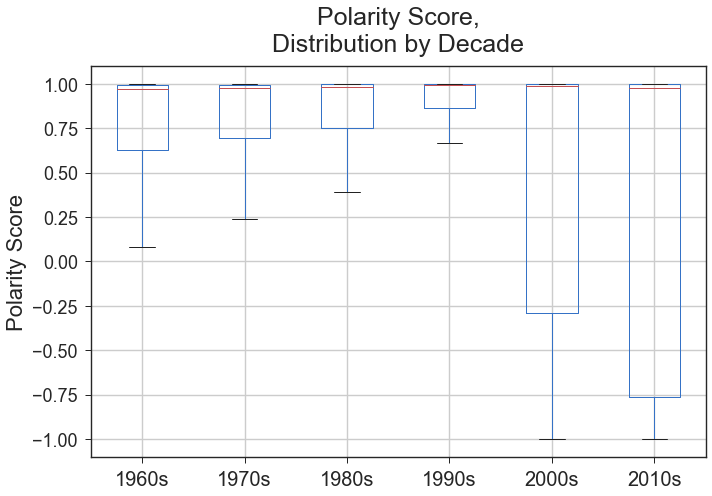

In [23]:
# plot the graph
df.boxplot('sentiment_polarity_score', 'decade', 
           showfliers=False, figsize=(10,7))

# prettify the graph
plt.title('Polarity Score,\nDistribution by Decade', 
          fontsize=25, pad=15)
plt.suptitle('')
plt.xlabel('')
plt.ylabel('Polarity Score', fontsize=22, labelpad=5)

# plot the labels
plt.xticks(fontsize=20)
plt.yticks(fontsize=18)

# prepare to save and display
plt.tight_layout()
# # uncomment to save
# plt.savefig('charts/polarity_score_boxplot.png', 
#             bbox_inches='tight', transparent=True)

plt.show()

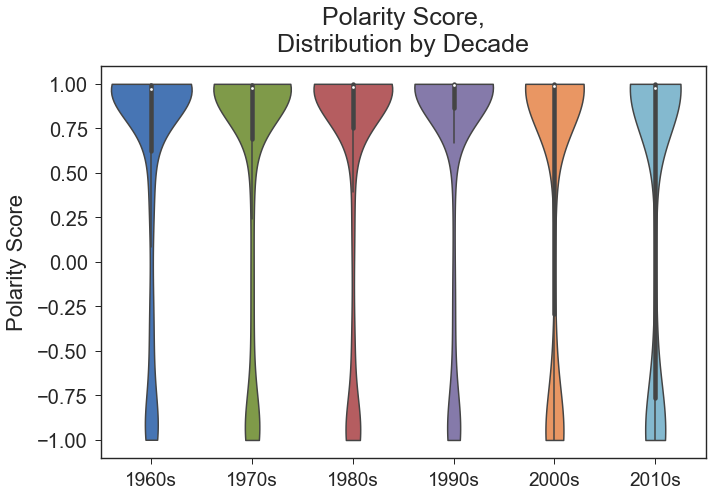

In [24]:
plt.figure(figsize=(10,7))

# plot the graph
sns.violinplot('decade', 'sentiment_polarity_score', data=df, showextrema=False, 
               cut=0
              )

# prettify the graph
plt.title('Polarity Score,\nDistribution by Decade', 
          fontsize=25, pad=15)
plt.suptitle('')
plt.xlabel('')
plt.ylabel('Polarity Score', fontsize=22, labelpad=10)

# plot the labels
plt.xticks(fontsize=19)
plt.yticks(fontsize=20)

# prepare to save and display
plt.tight_layout()
# # uncomment to save
# plt.savefig('charts/num_lines_boxplot.png', 
#             bbox_inches='tight', transparent=True)

plt.show()

- The first 4 decades appear to be nearly identical, getting progressively more positive through the 1990s.
- There is a notable shift in the 2000s and 2010s, with much larger distributions of negative songs, although neutral seems to be fairly equal in each decade. The range of each distribution also looks longer.
- Looking at polarity as a categorical variable may be able to tell me more.

### Polarity -- Stacked bar chart

[[go back to the top](#Song-Lyrics-Through-the-Years)]

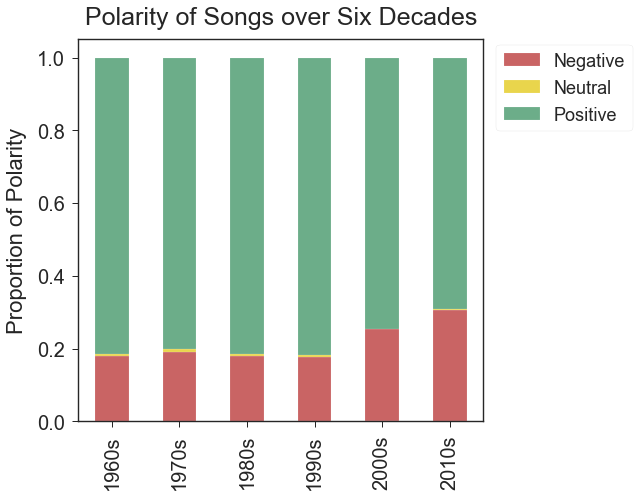

In [25]:
# proportion of polarity across decade
decade_polarity_dist = df.groupby('decade').\
    sentiment_polarity.value_counts(normalize=True).\
    unstack()

# plot the graph
decade_polarity_dist.plot(kind='bar', stacked=True, 
    figsize=(9,7), color=['firebrick', '#e1c400', 'seagreen'], 
    alpha=0.7, fontsize=14)

# prettify the graph
plt.title('Polarity of Songs over Six Decades', fontsize=25, pad=15)
plt.suptitle('')
plt.xlabel('')
plt.ylabel('Proportion of Polarity', fontsize=22, labelpad=10)

# plot the labels and legend
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);
plt.legend(['Negative', 'Neutral', 'Positive'], facecolor='white', 
           framealpha=1, bbox_to_anchor=(1.01, 1.01), fontsize=18)

# prepare to save and display
plt.tight_layout()
# # uncomment to save
# plt.savefig('charts/polarity_stackedbar.png', 
#             bbox_inches='tight', transparent=True)

plt.show()

In [26]:
# numerical representation
decade_polarity_dist

sentiment_polarity  negative   neutral  positive
decade                                          
1960s               0.180312  0.005848  0.813840
1970s               0.189218  0.010571  0.800211
1980s               0.180294  0.004193  0.815514
1990s               0.176128  0.005822  0.818049
2000s               0.252595       NaN  0.747405
2010s               0.305499  0.002037  0.692464

- This more or less confirms what I had written above, although the increase in negative songs doesn't look as intense as I would have thought.
- Top songs across decades are overwhelmingly positive and hardly ever neutral.

### Sentiment, subjectivity

[[go back to the top](#Song-Lyrics-Through-the-Years)]

- I wonder whether any decades tend to be more or less objective.
- I'll use TextBlob to obtain a sentiment score.

In [27]:
%%time

# create a column with the compound polarity score, 
# passing in the raw poem to TextBlob
df['sentiment_subjectivity_score'] = df['lyrics'].\
    apply(lambda x: TextBlob(x).sentiment.subjectivity)

CPU times: user 9.25 s, sys: 29.3 ms, total: 9.28 s
Wall time: 9.33 s


In [28]:
# subjectivity score stats as a whole
df.sentiment_subjectivity_score.describe()

count    4682.000000
mean        0.516232
std         0.132452
min         0.000000
25%         0.440237
50%         0.521374
75%         0.597288
max         1.000000
Name: sentiment_subjectivity_score, dtype: float64

In [29]:
# subjectivity score stast by movement
df.groupby('decade').sentiment_subjectivity_score.describe().T

decade        1960s       1970s       1980s       1990s       2000s  \
count   1026.000000  946.000000  954.000000  687.000000  578.000000   
mean       0.510658    0.513179    0.519326    0.526953    0.514920   
std        0.146933    0.141600    0.126704    0.118946    0.115595   
min        0.000000    0.000000    0.000000    0.000000    0.000000   
25%        0.424943    0.426684    0.450899    0.457898    0.441906   
50%        0.516594    0.520632    0.525346    0.529950    0.519000   
75%        0.603366    0.598050    0.596162    0.597242    0.579054   
max        1.000000    1.000000    0.933053    0.944444    0.928571   

decade       2010s  
count   491.000000  
mean      0.514293  
std       0.129343  
min       0.000000  
25%       0.443046  
50%       0.519501  
75%       0.594919  
max       1.000000

#### Statistical analysis

In [30]:
# one-way ANOVA
stats.f_oneway(
    df[df.decade == '1960s'].sentiment_subjectivity_score,
    df[df.decade == '1970s'].sentiment_subjectivity_score,
    df[df.decade == '1980s'].sentiment_subjectivity_score,
    df[df.decade == '1990s'].sentiment_subjectivity_score,
    df[df.decade == '2000s'].sentiment_subjectivity_score,
    df[df.decade == '2010s'].sentiment_subjectivity_score
)

F_onewayResult(statistic=1.5014660564581956, pvalue=0.18579127277953242)

- There is no statistical difference among the decades in terms of their subjectivity scores.

### Number of end rhymes

[[go back to the top](#Song-Lyrics-Through-the-Years)]

- I am somewhat at the mercy of whoever transcribed the songs lyrics here (and when they decided a line ends), but I wonder if there are any significant differences in rhyming across the decades.
- I'll count the number of end rhymes, i.e. lines where the last word rhymes with another line's last word.

In [31]:
%%time

# run custom function to count the number of end rhymes in a poem
df['num_end_rhymes'] = df.lyrics_lined.apply(end_rhyme_counter)

CPU times: user 2min 9s, sys: 263 ms, total: 2min 10s
Wall time: 2min 10s


In [32]:
# number of end rhymes stats as a whole
df.num_end_rhymes.describe()

count    4682.000000
mean       42.905596
std        75.531469
min         0.000000
25%         7.000000
50%        19.500000
75%        45.000000
max      1085.000000
Name: num_end_rhymes, dtype: float64

In [33]:
# number of end rhymes stats by movement
df.groupby('decade').num_end_rhymes.describe().T

decade        1960s       1970s       1980s       1990s        2000s  \
count   1026.000000  946.000000  954.000000  687.000000   578.000000   
mean      25.034113   30.963002   47.188679   57.799127    65.001730   
std       38.839555   48.320006   73.714019   93.752608   103.248829   
min        0.000000    0.000000    0.000000    0.000000     0.000000   
25%        5.000000    5.000000    8.000000   10.000000    12.000000   
50%       13.000000   16.000000   24.000000   25.000000    29.000000   
75%       28.000000   36.000000   52.000000   61.000000    72.750000   
max      418.000000  639.000000  741.000000  906.000000  1085.000000   

decade       2010s  
count   491.000000  
mean     48.087576  
std      97.578699  
min       0.000000  
25%       6.000000  
50%      19.000000  
75%      48.000000  
max     936.000000

#### Statistical analysis

In [34]:
# one-way ANOVA
stats.f_oneway(
    df[df.decade == '1960s'].num_end_rhymes,
    df[df.decade == '1970s'].num_end_rhymes,
    df[df.decade == '1980s'].num_end_rhymes,
    df[df.decade == '1990s'].num_end_rhymes,
    df[df.decade == '2000s'].num_end_rhymes,
    df[df.decade == '2010s'].num_end_rhymes
)

F_onewayResult(statistic=33.66408522310064, pvalue=6.937528687361328e-34)

- At least one statistically significant difference is present.
- I'll now perform two-sided t-tests on all possible combinations within these four categories.

In [35]:
# list of series on which to perform two-sided t-tests
num_end_rhymes_list = [
    df[df.decade == dec].num_end_rhymes for dec in df.decade.unique()
]

In [36]:
# test each combination
two_way_tests(num_end_rhymes_list, df.decade.unique())

{('1960s',
  '1970s'): Ttest_indResult(statistic=-3.013729501044505, pvalue=0.002613486419776132),
 ('1960s',
  '1980s'): Ttest_indResult(statistic=-8.448092050694799, pvalue=5.651155079341607e-17),
 ('1960s',
  '1990s'): Ttest_indResult(statistic=-9.9883296337237, pvalue=7.15244944288046e-23),
 ('1960s',
  '2000s'): Ttest_indResult(statistic=-11.086838741618104, pvalue=1.4216708219722727e-27),
 ('1960s',
  '2010s'): Ttest_indResult(statistic=-6.5607740754773785, pvalue=7.327078393857703e-11),
 ('1970s',
  '1980s'): Ttest_indResult(statistic=-5.669244331119971, pvalue=1.6545122188212623e-08),
 ('1970s',
  '1990s'): Ttest_indResult(statistic=-7.533874824083113, pvalue=8.117865605158037e-14),
 ('1970s',
  '2000s'): Ttest_indResult(statistic=-8.700850929728997, pvalue=8.394182280101181e-18),
 ('1970s',
  '2010s'): Ttest_indResult(statistic=-4.448999035489759, pvalue=9.293113872140216e-06),
 ('1980s',
  '1990s'): Ttest_indResult(statistic=-2.564232099953642, pvalue=0.010428867250104045),
 

- All tests but three show statistical signficance.

### Number of end rhymes -- Boxplot

[[go back to the top](#Song-Lyrics-Through-the-Years)]

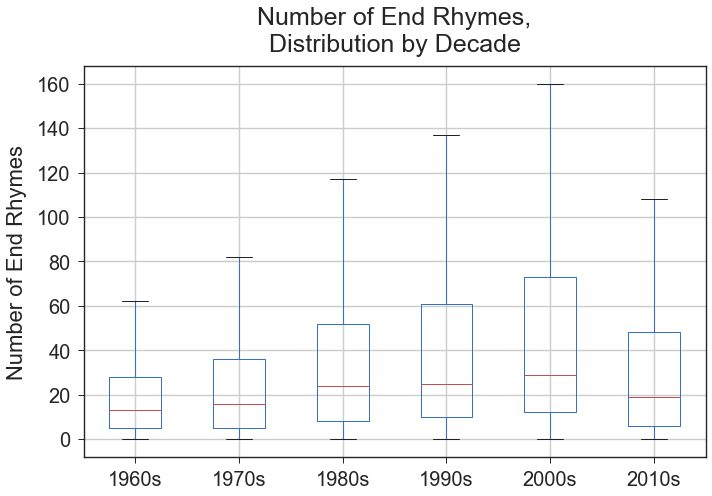

In [37]:
# plot the graph
df.boxplot('num_end_rhymes', 'decade', 
           showfliers=False, figsize=(10,7))

# prettify the graph
plt.title('Number of End Rhymes,\nDistribution by Decade', 
          fontsize=25, pad=15)
plt.suptitle('')
plt.xlabel('')
plt.ylabel('Number of End Rhymes', fontsize=22, labelpad=10)

# plot the labels
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# prepare to save and display
plt.tight_layout()
# # uncomment to save
# plt.savefig('charts/num_end_rhymes_boxplot.png', 
#             bbox_inches='tight', transparent=True)

plt.show()

- Unsurprisingly, wordier decades seem to also have more end rhymes.
- Surprisingly, they don't seem all that strongly correlated.

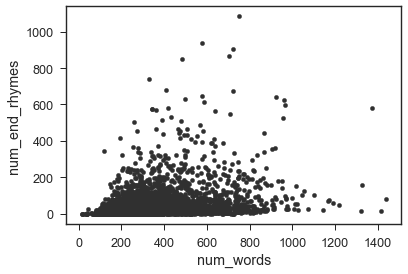

In [38]:
df.plot.scatter('num_words', 'num_end_rhymes');

In [39]:
df.num_words.corr(df.num_end_rhymes)

0.31437603830107114

- I'll create a ratio to put this information onto a more uniform scale.

### Ratio of end rhymes

[[go back to the top](#Song-Lyrics-Through-the-Years)]

- Looking at the ratio of end rhymes to the length of the song may give me a better idea about how prevalent any rhyme scheme actually is.

In [40]:
# create column of the ratio of end rhymes to the total lines
df['end_rhyme_ratio'] = df.num_end_rhymes / df.num_words

In [41]:
# end rhyme ratio stats as a whole
df.end_rhyme_ratio.describe()

count    4682.000000
mean        0.127856
std         0.189627
min         0.000000
25%         0.026801
50%         0.067450
75%         0.150545
max         2.915254
Name: end_rhyme_ratio, dtype: float64

In [42]:
# end rhyme ratio stats by decade
df.groupby('decade').end_rhyme_ratio.describe().T

decade        1960s       1970s       1980s       1990s       2000s  \
count   1026.000000  946.000000  954.000000  687.000000  578.000000   
mean       0.118725    0.120451    0.151009    0.141126    0.125251   
std        0.180546    0.172910    0.207484    0.204893    0.179473   
min        0.000000    0.000000    0.000000    0.000000    0.000000   
25%        0.029165    0.024907    0.033679    0.028350    0.027476   
50%        0.069019    0.068197    0.081307    0.071698    0.061445   
75%        0.142028    0.146228    0.188214    0.169427    0.150113   
max        2.915254    1.927203    2.266055    1.675439    1.761411   

decade       2010s  
count   491.000000  
mean      0.100714  
std       0.186860  
min       0.000000  
25%       0.015092  
50%       0.043956  
75%       0.101856  
max       1.662592

#### Statistical analysis

In [43]:
# one-way ANOVA
stats.f_oneway(
    df[df.decade == '1960s'].end_rhyme_ratio,
    df[df.decade == '1970s'].end_rhyme_ratio,
    df[df.decade == '1980s'].end_rhyme_ratio,
    df[df.decade == '1990s'].end_rhyme_ratio,
    df[df.decade == '2000s'].end_rhyme_ratio,
    df[df.decade == '2010s'].end_rhyme_ratio
)

F_onewayResult(statistic=6.3513532831276205, pvalue=6.938401425122079e-06)

- At least one statistically significant difference is present.
- I'll now perform two-sided t-tests on all possible combinations within these four categories.

In [44]:
# list of series on which to perform two-sided t-tests
end_rhyme_ratio_list = [
    df[df.decade == dec].end_rhyme_ratio for dec in df.decade.unique()
]

In [45]:
# test each combination
two_way_tests(end_rhyme_ratio_list, df.decade.unique())

{('1960s',
  '1970s'): Ttest_indResult(statistic=-0.2165549063879777, pvalue=0.8285776531880658),
 ('1960s',
  '1980s'): Ttest_indResult(statistic=-3.700192679268819, pvalue=0.000221321723818818),
 ('1960s',
  '1990s'): Ttest_indResult(statistic=-2.383149414872916, pvalue=0.017273796941840384),
 ('1960s',
  '2000s'): Ttest_indResult(statistic=-0.6965970521507897, pvalue=0.486156060576053),
 ('1960s',
  '2010s'): Ttest_indResult(statistic=1.7972500572627665, pvalue=0.07249501817904723),
 ('1970s',
  '1980s'): Ttest_indResult(statistic=-3.4858260049381795, pvalue=0.0005017731044366379),
 ('1970s',
  '1990s'): Ttest_indResult(statistic=-2.205290375043121, pvalue=0.02757280601517512),
 ('1970s',
  '2000s'): Ttest_indResult(statistic=-0.5182657517456771, pvalue=0.6043481954249033),
 ('1970s',
  '2010s'): Ttest_indResult(statistic=1.9958071415501044, pvalue=0.04614365246691714),
 ('1980s',
  '1990s'): Ttest_indResult(statistic=0.9568596683976194, pvalue=0.33877920433792696),
 ('1980s',
  '20

- Most results show statistical signficance, although the ones that don't are fairly surprising.

### Ratio of end rhymes -- Boxplot

[[go back to the top](#Song-Lyrics-Through-the-Years)]

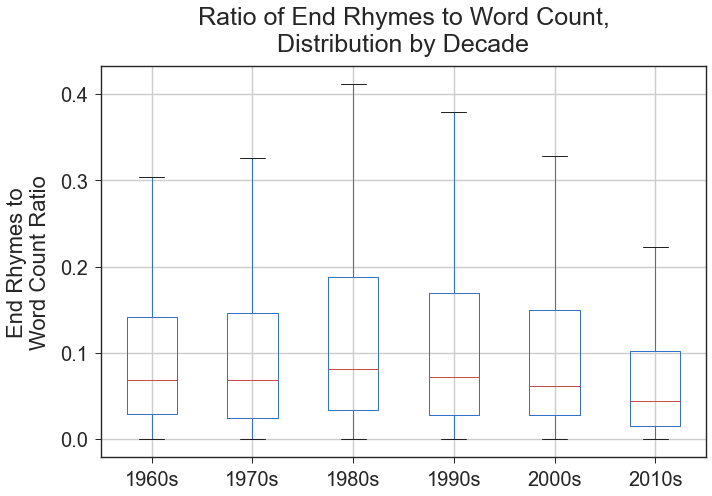

In [46]:
# plot the graph
df.boxplot('end_rhyme_ratio', 'decade', 
           showfliers=False, figsize=(10,7))

# prettify the graph
plt.title('Ratio of End Rhymes to Word Count,\nDistribution by Decade', 
          fontsize=25, pad=15)
plt.suptitle('')
plt.xlabel('')
plt.ylabel('End Rhymes to\nWord Count Ratio', fontsize=22, labelpad=10)

# plot the labels
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# prepare to save and display
plt.tight_layout()
# # uncomment to save
# plt.savefig('charts/ratio_end_rhymes_boxplot.png', 
#             bbox_inches='tight', transparent=True)

plt.show()

- This plot paints a more accurate picture.
    - Rhyming occurs at a fairly constant rate across decades.
    - You could argue that 1980s Top 10 songs are the "rhymeist", and Top 10 songs from the 2010s are the least "rhymey".
- I'll check if this is too strongly correlated with the number of end rhymes.

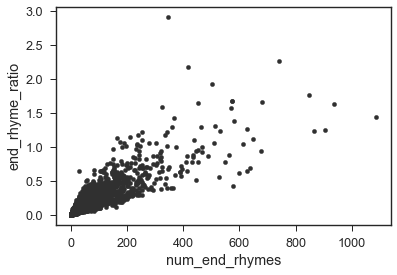

In [47]:
df.plot.scatter('num_end_rhymes', 'end_rhyme_ratio');

In [48]:
# check correlation
df.num_end_rhymes.corr(df.end_rhyme_ratio)

0.8628417540948637

- They are very positively correlated, so I may need to drop one when I get to modeling.
    
### End rhymes, categorical

[[go back to the top](#Song-Lyrics-Through-the-Years)]

- **NOTE**: Feel free to play around with the metric; first, I tried separating based on 0 end rhymes vs any number of end rhymes.
    - Increasing the 0 value yielded more interesting results (and also weeds out some incidental end rhymes, including those of repeated words).
    - Another tactic is setting a minimum ratio of end rhymes to lines, as seen below.

In [49]:
# create a yes or no column for whether or not end rhymes occur at least 10% of the time
df['end_rhyme'] = np.where(df.end_rhyme_ratio >= 0.071942, 1, 0)

In [50]:
# proportion as a whole
df.end_rhyme.value_counts(normalize=True)

0    0.52029
1    0.47971
Name: end_rhyme, dtype: float64

In [51]:
# proportion across movements
df.groupby('decade').end_rhyme.value_counts(normalize=True)

decade  end_rhyme
1960s   0            0.517544
        1            0.482456
1970s   0            0.513742
        1            0.486258
1980s   1            0.541929
        0            0.458071
1990s   0            0.502183
        1            0.497817
2000s   0            0.553633
        1            0.446367
2010s   0            0.645621
        1            0.354379
Name: end_rhyme, dtype: float64

### End rhymes -- Stacked bar chart

[[go back to the top](#Song-Lyrics-Through-the-Years)]

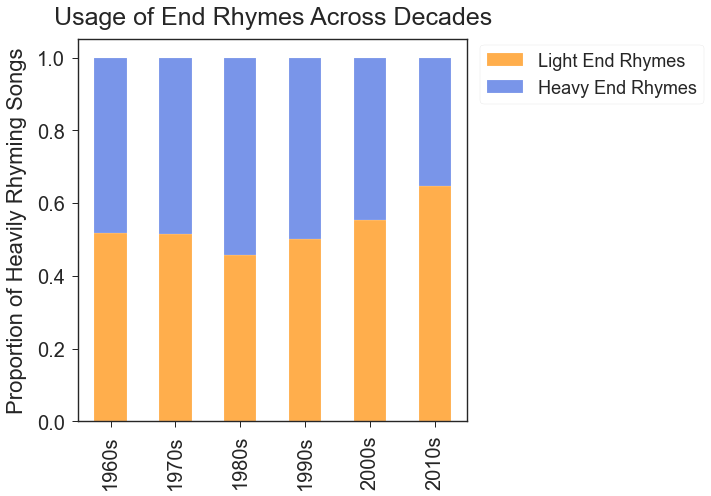

In [52]:
# proportion of end rhymes across decades
decade_rhyme_dist = df.groupby('decade').end_rhyme.\
    value_counts(normalize=True).unstack()

# plot the graph
decade_rhyme_dist.plot(kind='bar', stacked=True, 
    figsize=(10,7), color=['darkorange', 'royalblue'], 
    alpha=.70, fontsize=14)

# prettify the graph
plt.title('Usage of End Rhymes Across Decades', 
          fontsize=25, pad=15)
plt.suptitle('')
plt.xlabel('')
plt.ylabel('Proportion of Heavily Rhyming Songs', 
           fontsize=22, labelpad=10)

# plot the labels and and legends
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);
plt.legend(['Light End Rhymes', 'Heavy End Rhymes'], facecolor='white', 
           framealpha=1, bbox_to_anchor=(1.01, 1.01), 
           fontsize=18)

# prepare to save and display
plt.tight_layout()
# # uncomment to save
# plt.savefig('charts/end_rhymes_stackedbar.png', 
#             bbox_inches='tight', transparent=True)

plt.show()

In [53]:
# numerical representation
decade_rhyme_dist

end_rhyme         0         1
decade                       
1960s      0.517544  0.482456
1970s      0.513742  0.486258
1980s      0.458071  0.541929
1990s      0.502183  0.497817
2000s      0.553633  0.446367
2010s      0.645621  0.354379

- Another graph showing similar results more clearly.

### Syllables per word

[[go back to the top](#Song-Lyrics-Through-the-Years)]

- Count the number of total syllables.
- Divide by number of words per song.

In [54]:
# divide number of syllables by number of words
df['avg_syllables_word'] = df.lyrics_lined.apply(
    syllable_counter) / df.num_words

In [55]:
# average syllables per word stats as a whole
df.avg_syllables_word.describe()

count    4682.000000
mean        1.167500
std         0.072709
min         1.000000
25%         1.120147
50%         1.158537
75%         1.204585
max         2.500000
Name: avg_syllables_word, dtype: float64

In [56]:
# average syllables per word stats by decade
df.groupby('decade').avg_syllables_word.describe().T

decade        1960s       1970s       1980s       1990s       2000s  \
count   1026.000000  946.000000  954.000000  687.000000  578.000000   
mean       1.170326    1.172583    1.177733    1.167701    1.153850   
std        0.084982    0.074762    0.072875    0.066174    0.056943   
min        1.000000    1.000000    1.018018    1.026968    1.040248   
25%        1.117647    1.122807    1.130080    1.123122    1.113742   
50%        1.161341    1.163504    1.170326    1.159309    1.147123   
75%        1.210437    1.212121    1.216306    1.204724    1.186739   
max        2.500000    1.804348    1.535714    1.537500    1.379085   

decade       2010s  
count   491.000000  
mean      1.147700  
std       0.058782  
min       1.009804  
25%       1.109163  
50%       1.141509  
75%       1.178937  
max       1.494208

- The numbers look fairly similar. I'll do some statistical analyses.

#### Statistical analysis

In [57]:
# one-way ANOVA
stats.f_oneway(
    df[df.decade == '1960s'].avg_syllables_word,
    df[df.decade == '1970s'].avg_syllables_word,
    df[df.decade == '1980s'].avg_syllables_word,
    df[df.decade == '1990s'].avg_syllables_word,
    df[df.decade == '2000s'].avg_syllables_word,
    df[df.decade == '2010s'].avg_syllables_word
)

F_onewayResult(statistic=16.645250422260972, pvalue=2.490081798150837e-16)

- At least one statistically significant difference is present.
- I'll now perform two-sided t-tests on all possible combinations within these four categories.

In [58]:
# list of series on which to perform two-sided t-tests
avg_syllables_word_list = [
    df[df.decade == dec].avg_syllables_word for dec in df.decade.unique()
]

In [59]:
# test each combination
two_way_tests(avg_syllables_word_list, df.decade.unique())

{('1960s',
  '1970s'): Ttest_indResult(statistic=-0.6239300612503867, pvalue=0.5327457559157609),
 ('1960s',
  '1980s'): Ttest_indResult(statistic=-2.0745807160208276, pvalue=0.038154457825951664),
 ('1960s',
  '1990s'): Ttest_indResult(statistic=0.6828832318518789, pvalue=0.49477307864991293),
 ('1960s',
  '2000s'): Ttest_indResult(statistic=4.163910742597047, pvalue=3.294921225673201e-05),
 ('1960s',
  '2010s'): Ttest_indResult(statistic=5.321466499425224, pvalue=1.1838263643627476e-07),
 ('1970s',
  '1980s'): Ttest_indResult(statistic=-1.520446457175836, pvalue=0.12856536906147117),
 ('1970s',
  '1990s'): Ttest_indResult(statistic=1.3664505452670999, pvalue=0.17198593862000994),
 ('1970s',
  '2000s'): Ttest_indResult(statistic=5.1758873091615225, pvalue=2.570631783950383e-07),
 ('1970s',
  '2010s'): Ttest_indResult(statistic=6.416756511788102, pvalue=1.8863206367414642e-10),
 ('1980s',
  '1990s'): Ttest_indResult(statistic=2.8580710275004715, pvalue=0.00431610698476835),
 ('1980s',


- A lot of statistical significance, but not across all combinations.

### Syllables per word -- Boxplot

[[go back to the top](#Song-Lyrics-Through-the-Years)]

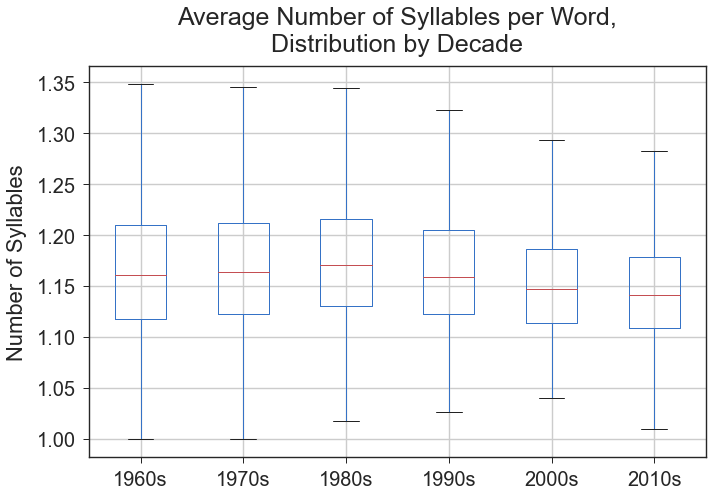

In [60]:
# plot the graph
df.boxplot('avg_syllables_word', 'decade', 
           showfliers=False, figsize=(10,7))

# prettify the graph
plt.title('Average Number of Syllables per Word,\nDistribution by Decade', 
          fontsize=25, pad=15)
plt.suptitle('')
plt.xlabel('')
plt.ylabel('Number of Syllables', 
           fontsize=22, labelpad=10)

# plot the labels
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# prepare to save and display
plt.tight_layout()
# # uncomment to save
# plt.savefig('charts/avg_syllables_word_boxplot.png', 
#             bbox_inches='tight', transparent=True)

plt.show()

- The medians across the decades are fairly similar, although the 2000s and 2010s are noticeably lower in median and range.

### Lexical richness

[[go back to the top](#Song-Lyrics-Through-the-Years)]

- Count the number of unique words.
- Divide by number of words per poem.

In [61]:
# divide number of unique words by total words
df['lexical_richness'] = df.lyrics_lined.apply(
    unique_word_counter) / df.num_words

In [62]:
# lexical richness as a whole
df.lexical_richness.describe()

count    4682.000000
mean        0.350012
std         0.106779
min         0.053571
25%         0.275421
50%         0.338105
75%         0.414488
max         0.894737
Name: lexical_richness, dtype: float64

In [63]:
# lexical richness as a whole by decade
df.groupby('decade').lexical_richness.describe().T

decade        1960s       1970s       1980s       1990s       2000s  \
count   1026.000000  946.000000  954.000000  687.000000  578.000000   
mean       0.395545    0.367066    0.349897    0.330351    0.304836   
std        0.113485    0.113665    0.102560    0.095333    0.078445   
min        0.056306    0.053571    0.096573    0.084605    0.109195   
25%        0.313593    0.291776    0.279033    0.259744    0.247837   
50%        0.390327    0.356220    0.335964    0.321321    0.301892   
75%        0.465596    0.433300    0.412711    0.390598    0.353810   
max        0.842105    0.894737    0.803571    0.703704    0.775000   

decade       2010s  
count   491.000000  
mean      0.302921  
std       0.081018  
min       0.062857  
25%       0.244863  
50%       0.299363  
75%       0.355926  
max       0.638462

- Avant-Garde appears to be the most rich within every quartile, the mean, and the minimum.
- The other three movements have very similar numbers, other than the minimum.

#### Statistical analysis

In [64]:
# one-way ANOVA
stats.f_oneway(
    df[df.decade == '1960s'].lexical_richness,
    df[df.decade == '1970s'].lexical_richness,
    df[df.decade == '1980s'].lexical_richness,
    df[df.decade == '1990s'].lexical_richness,
    df[df.decade == '2000s'].lexical_richness,
    df[df.decade == '2010s'].lexical_richness
)

F_onewayResult(statistic=95.30948597125995, pvalue=6.934097182800768e-96)

- At least one statistically significant difference is present.
- I'll now perform two-sided t-tests on all possible combinations within these four categories.

In [65]:
# list of series on which to perform two-sided t-tests
lexical_richness_list = [
    df[df.decade == dec].lexical_richness for dec in df.decade.unique()
]

In [66]:
# test each combination
two_way_tests(lexical_richness_list, df.decade.unique())

{('1960s',
  '1970s'): Ttest_indResult(statistic=5.563078165054445, pvalue=3.0124517817153074e-08),
 ('1960s',
  '1980s'): Ttest_indResult(statistic=9.366303641821661, pvalue=1.974552020977314e-20),
 ('1960s',
  '1990s'): Ttest_indResult(statistic=12.408080689472156, pvalue=6.480719065988069e-34),
 ('1960s',
  '2000s'): Ttest_indResult(statistic=17.05640968044832, pvalue=4.5317799836850573e-60),
 ('1960s',
  '2010s'): Ttest_indResult(statistic=16.21428033688354, pvalue=1.2086952352537907e-54),
 ('1970s',
  '1980s'): Ttest_indResult(statistic=3.4572930700897957, pvalue=0.0005576574878519462),
 ('1970s',
  '1990s'): Ttest_indResult(statistic=6.887726433709571, pvalue=8.066071609349393e-12),
 ('1970s',
  '2000s'): Ttest_indResult(statistic=11.583764340473005, pvalue=8.495514022973885e-30),
 ('1970s',
  '2010s'): Ttest_indResult(statistic=11.123092703195095, pvalue=1.2578928777374682e-27),
 ('1980s',
  '1990s'): Ttest_indResult(statistic=3.9219003439136872, pvalue=9.147837060736188e-05),
 

- This variable appears to be statistically significant across every combination of decades other than between the 2000s and 2010s.

### Lexical richness -- Boxplot

[[go back to the top](#Song-Lyrics-Through-the-Years)]

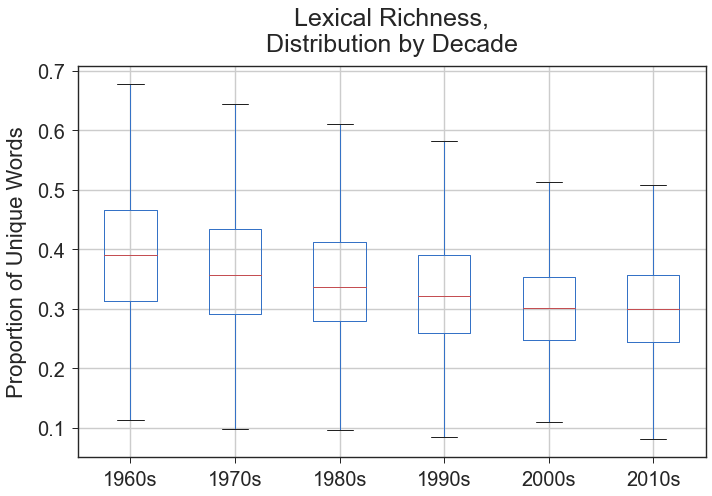

In [67]:
# plot the graph
df.boxplot('lexical_richness', 'decade', 
           showfliers=False, figsize=(10,7))

# prettify the graph
plt.title('Lexical Richness,\nDistribution by Decade', 
          fontsize=25, pad=15)
plt.suptitle('')
plt.xlabel('')
plt.ylabel('Proportion of Unique Words', 
           fontsize=22, labelpad=10)

# plot the labels
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# prepare to save and display
plt.tight_layout()
# # uncomment to save
# plt.savefig('charts/lexical_richness_boxplot.png', 
#             bbox_inches='tight', transparent=True)

plt.show()

- Lexical richness has decreased consistently over time, with the 2000s and 2010s indeed appearing quite similar.
- Overall, unsurprisingly, songs are rather repetitious.

## Experiments

[[go back to the top](#Song-Lyrics-Through-the-Years)]

In [68]:
df['lyrics_lower'] = df.lyrics.str.lower()

In [69]:
df['self_reference'] = np.where(df.lyrics.map(lambda x: len(x.split())) > df.lyrics_no_artist.map(lambda x: len(x.split())), 1, 0)

df.self_reference.value_counts()

0    4262
1     420
Name: self_reference, dtype: int64

In [70]:
df.groupby('decade').self_reference.value_counts(normalize=True)

decade  self_reference
1960s   0                 0.976608
        1                 0.023392
1970s   0                 0.969345
        1                 0.030655
1980s   0                 0.959119
        1                 0.040881
1990s   0                 0.851528
        1                 0.148472
2000s   0                 0.752595
        1                 0.247405
2010s   0                 0.830957
        1                 0.169043
Name: self_reference, dtype: float64

In [71]:
df[df.decade == '1960s'].artist.unique()

array(['andy williams', 'anita bryant', 'annette', 'bert kaempfert',
       'billy bland', 'bob luman', 'bobby darin', 'bobby rydell',
       'bobby vee', 'brenda lee', 'brian hyland', 'brook benton',
       'chubby checker', 'connie francis', 'connie stevens',
       'conway twitty', 'dinah washington and brook benton',
       'dion and the belmonts', 'donnie brooks', 'duane eddy',
       'elvis presley', 'fabian', 'fats domino', 'floyd cramer',
       'frankie avalon', 'freddy cannon', 'gary', 'guy mitchell',
       'hank ballard and the midnighters', 'hank locklin',
       'hollywood argyles', 'jack scott', 'jackie wilson', 'jeanne black',
       'jerry butler', 'jim reeves', 'jimmy charles', 'jimmy clanton',
       'jimmy jones', 'joe jones', 'johnny burnette', 'johnny horton',
       'johnny preston', 'johnny tillotson',
       'kathy young and the innocents', 'larry verne', 'lolita',
       'mark dinning', 'marty robbins', 'marv johnson',
       'maurice williams and the zodiacs'

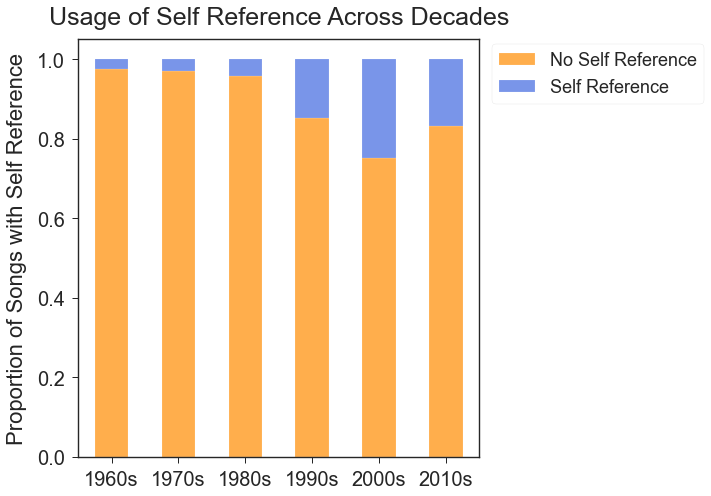

In [72]:
# proportion of self-references across decades
decade_selfref_dist = df.groupby('decade').self_reference.\
    value_counts(normalize=True).unstack()

# plot the graph
decade_selfref_dist.plot(kind='bar', stacked=True, 
    figsize=(10,7), color=['darkorange', 'royalblue'], 
    alpha=.70, fontsize=14)

# prettify the graph
plt.title('Usage of Self Reference Across Decades', 
          fontsize=25, pad=15)
plt.suptitle('')
plt.xlabel('')
plt.ylabel('Proportion of Songs with Self Reference', 
           fontsize=22, labelpad=10)

# plot the labels and and legends
plt.xticks(fontsize=20, rotation=0)
plt.yticks(fontsize=20);
plt.legend(['No Self Reference', 'Self Reference'], facecolor='white', 
           framealpha=1, bbox_to_anchor=(1.01, 1.01), 
           fontsize=18)

# prepare to save and display
plt.tight_layout()
# # uncomment to save
# plt.savefig('charts/end_rhymes_stackedbar.png', 
#             bbox_inches='tight', transparent=True)

plt.show()

In [75]:
# temp = df[(df.decade == '1990s') & (df.self_reference == 1)]

# temp

In [76]:
# print(temp.loc[1051, 'lyrics'])

In [ ]:
set(temp.loc[9, 'lyrics'].split()) - set(temp.loc[9, 'lyrics_no_artist'].split())

In [ ]:
please break code

In [ ]:
df.head()

In [ ]:
len(df[df.lyrics_lower.str.contains('ladies and gentlemen')])

# Step 4: Natural language processing

[[go back to the top](#Song-Lyrics-Through-the-Years)]

- Process the text and look at the most frequent words.
- First, prepare a list of stop words. This will include:
    - NLTK stop words.
    - Artist names (these were removed in the [previous notebook](02_data_cleaning.ipynb).
    - Words of questionable value discovered in the first round of EDA.
- Lemmatize.

In [77]:
# start with NLTK stop words
stop_words = stopwords.words('english')

# words found in the initial round of EDA that 
# don't provide much meaning
stop_words.extend(['get', 'like', 'yeah', 'one', 
                   'would', 'ooh'])

- Create a clean string column.

In [78]:
%%time

# create column using custom text processing function
# NOTE: includes lemmatization
df['lyrics_cleaned'] = df.lyrics_no_artist.apply(
    lambda x: clean_text(x, stop_words))

CPU times: user 1min 43s, sys: 10.9 s, total: 1min 53s
Wall time: 1min 54s


In [79]:
# check out an example
print(f'BEFORE:\n{df.loc[0, "lyrics_no_artist"]}')
print('\n' + '-' * 75 + '\n')
print(f'AFTER:\n{df.loc[0, "lyrics_cleaned"]}')

BEFORE:
i've traveled far, the land and the sea
beautiful places i happened to be
one little town i'll never forget
is lourdes, the village of st. bernadette

ave, ave, ave ma-ri-a
ave, ave, ave ma-ri-i-ia

there, like a dream, this wonderful night
i gazed at the grotto aglow in the light
a feeling divine swept over me there
i fell to my knees as i whispered the prayer

ave, ave, ave ma-ri-a
ave, ave, ave ma-ri-i-ia

now i am home, i'm happy to be
telling of places i've traveled to see
one little town i'll never forget
is lourdes, the village of st. bernadette

ave, ave, ave ma-ri-a
ave, ave, ave ma-ri-i-ia

ave, ave, ave ma-ri-a
ave, ave, ave ma-ri-a

---------------------------------------------------------------------------

AFTER:
travel far land sea beautiful place happen little town never forget lourdes village bernadette ave ave ave maria ave ave ave mariiia dream wonderful night gaze grotto aglow light feel divine swept fell knee whisper prayer ave ave ave maria ave ave ave mar

### Total word counts and vocabulary 

[[go back to the top](#Song-Lyrics-Through-the-Years)]

#### Before processing

In [80]:
# join all pre-processed poems into one string
big_string_pre = ' '.join(df.lyrics)
big_string_pre[:1000]

"i've traveled far, the land and the sea\nbeautiful places i happened to be\none little town i'll never forget\nis lourdes, the village of st. bernadette\n\nave, ave, ave ma-ri-a\nave, ave, ave ma-ri-i-ia\n\nthere, like a dream, this wonderful night\ni gazed at the grotto aglow in the light\na feeling divine swept over me there\ni fell to my knees as i whispered the prayer\n\nave, ave, ave ma-ri-a\nave, ave, ave ma-ri-i-ia\n\nnow i am home, i'm happy to be\ntelling of places i've traveled to see\none little town i'll never forget\nis lourdes, the village of st. bernadette\n\nave, ave, ave ma-ri-a\nave, ave, ave ma-ri-i-ia\n\nave, ave, ave ma-ri-a\nave, ave, ave ma-ri-a oh, come along with me\nto my little corner of the world\nand dream a little dream\nin my little corner of the world\n\ntonight, my love\nwe'll share a sweet embrace\nwe'll soon forget\nthere's any other place\n\nand if you care to stay\nin my little corner of the world\nthen we can hide away\nin my little corner of the 

In [81]:
# split string into all words in corpus
all_words = big_string_pre.split()

# total words
len(all_words)

1527694

In [82]:
# unique words (vocabulary)
len(list(set(all_words)))

44658

#### After lemmatizing and removing stop words

In [83]:
# join all processed poems into one string
big_string_proc = ' '.join(df.lyrics_cleaned)
big_string_proc[:1000]

'travel far land sea beautiful place happen little town never forget lourdes village bernadette ave ave ave maria ave ave ave mariiia dream wonderful night gaze grotto aglow light feel divine swept fell knee whisper prayer ave ave ave maria ave ave ave mariiia home happy tell place travel see little town never forget lourdes village bernadette ave ave ave maria ave ave ave mariiia ave ave ave maria ave ave ave maria come along little corner world dream little dream little corner world tonight love share sweet embrace soon forget place care stay little corner world hide away little corner world always knew find someone welcome little corner world care stay little corner world hide away little corner world always knew find someone welcome little corner world realize way eye deceive tender look mistook love take away flower give send kind remind paper rose paper rose real rose seem imitation imitation love thought perfect lover seem full sweetness start big red rise make paper sweetness h

In [84]:
# split string into processed words in corpus
all_words_proc = big_string_proc.split()

# total processed words
len(all_words_proc)

655303

In [85]:
# unique processed words (vocabulary)
len(list(set(all_words_proc)))

20838

## Most frequent words

[[go back to the top](#Song-Lyrics-Through-the-Years)]

- Use processed text.

In [86]:
# create dictionary of word counts
fdist = FreqDist(all_words_proc)

# convert word counts to dataframe
fdist_df = pd.DataFrame(data=fdist.values(), 
                        index=fdist.keys(), 
                        columns=['word_count'])
fdist_df = fdist_df.sort_values('word_count', 
                                ascending=False)

In [87]:
# look at the top 25 words in the processed corpus
top_25 = fdist_df.iloc[:25,:]
top_25

word_count
love        17304
know        11239
want        10452
baby         9933
say          7849
come         7070
make         7026
let          6811
time         5607
see          5554
take         5496
girl         5384
feel         4892
never        4849
cause        4754
way          4617
give         4437
need         3900
tell         3806
back         3769
right        3705
night        3647
well         3524
heart        3385
look         3150

### Most frequent words overall

[[go back to the top](#Song-Lyrics-Through-the-Years)]

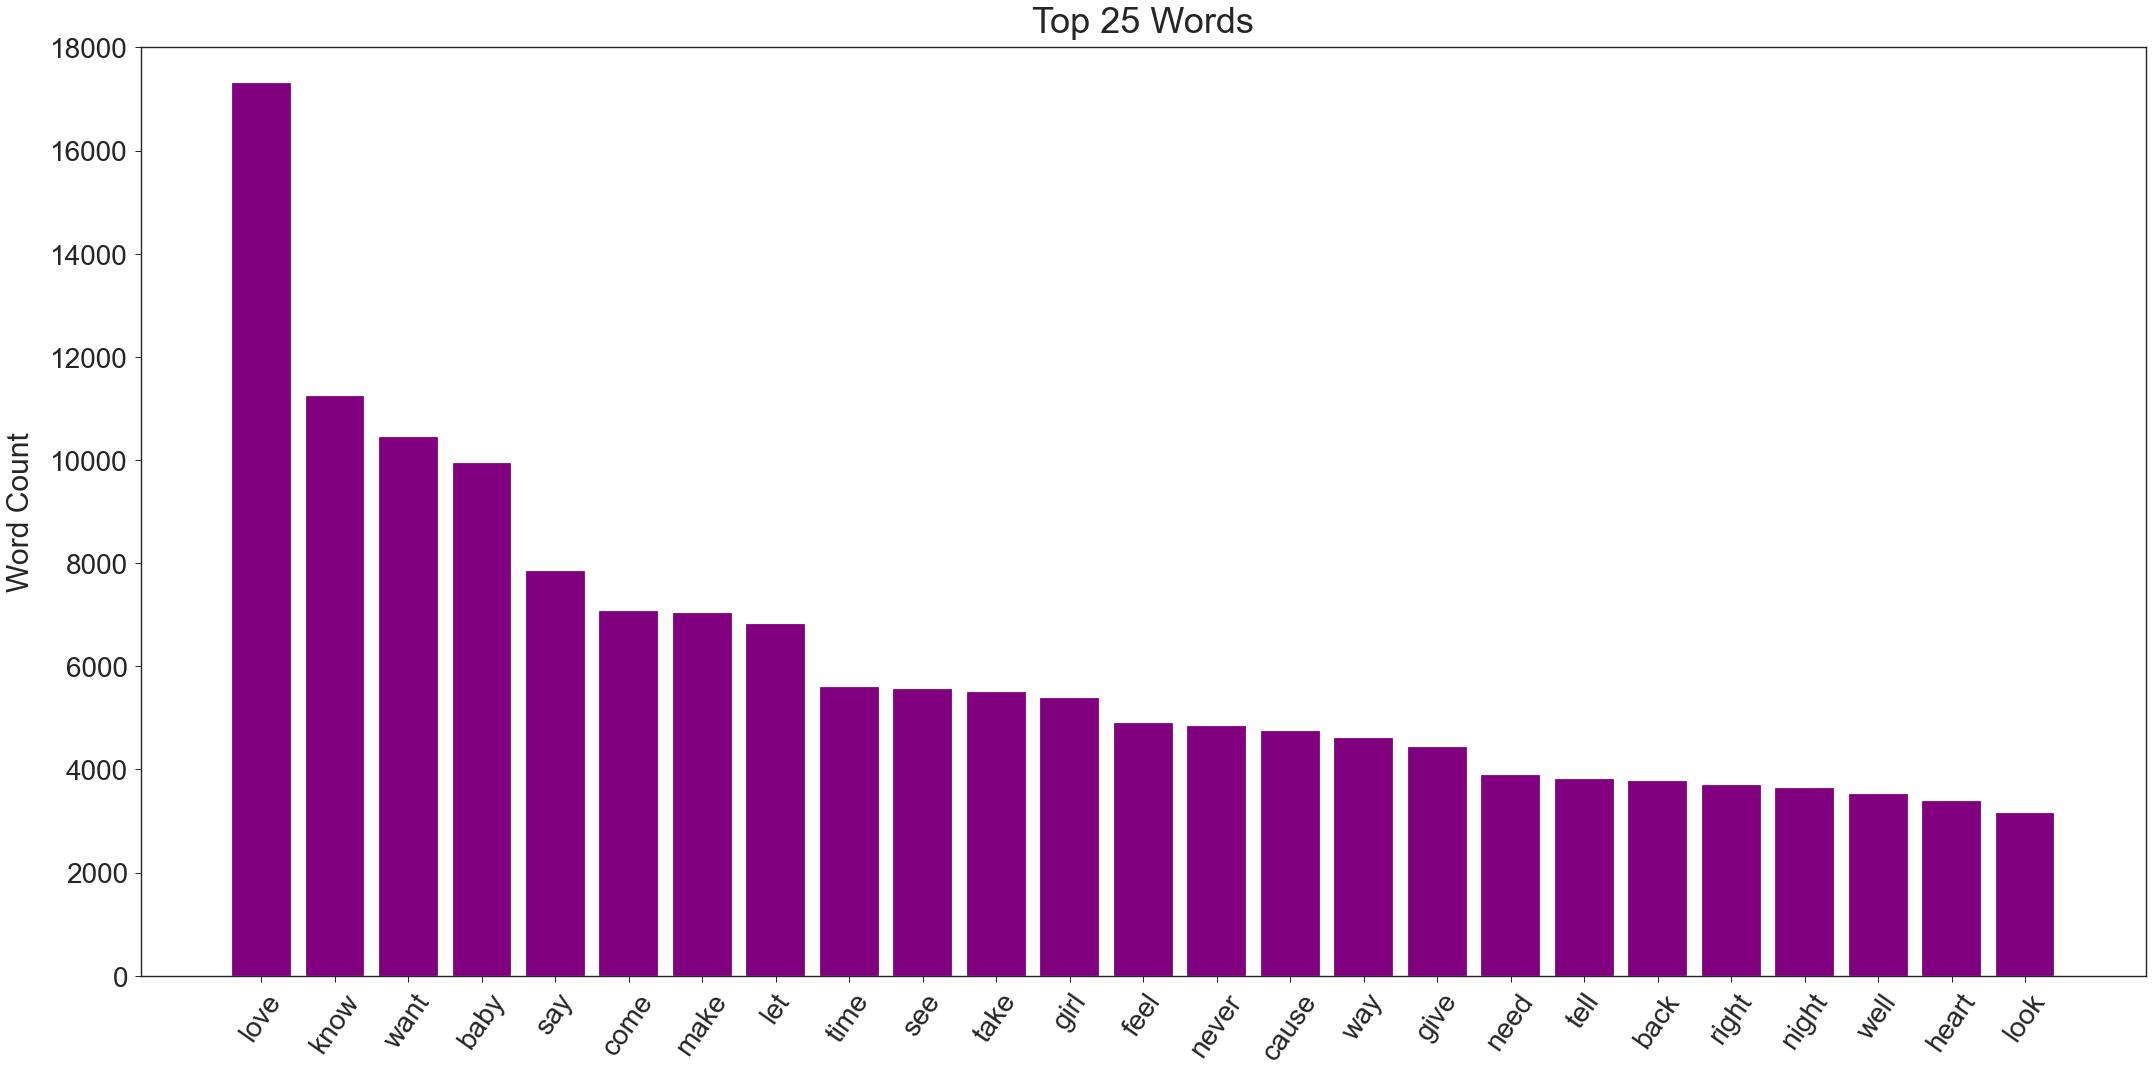

In [89]:
# create labels and prettify the plot
plt.figure(figsize=(30,15))
plt.title('Top 25 Words', fontsize=36, pad=15)
plt.ylabel('Word Count', fontsize=30, labelpad=15)
plt.xticks(rotation=55, fontsize=28)
plt.yticks(fontsize=28)
plt.ylim(bottom=0, top=18000)

# plot top 25 words
plt.bar(top_25.index, top_25.word_count, color='purple')

# prepare to save and display
plt.tight_layout()
# # uncomment to save
# plt.savefig('charts/top25_words_bar.png', 
#             bbox_inches='tight', transparent=True)

plt.show()

### Most frequent words by decade

[[go back to the top](#Song-Lyrics-Through-the-Years)]

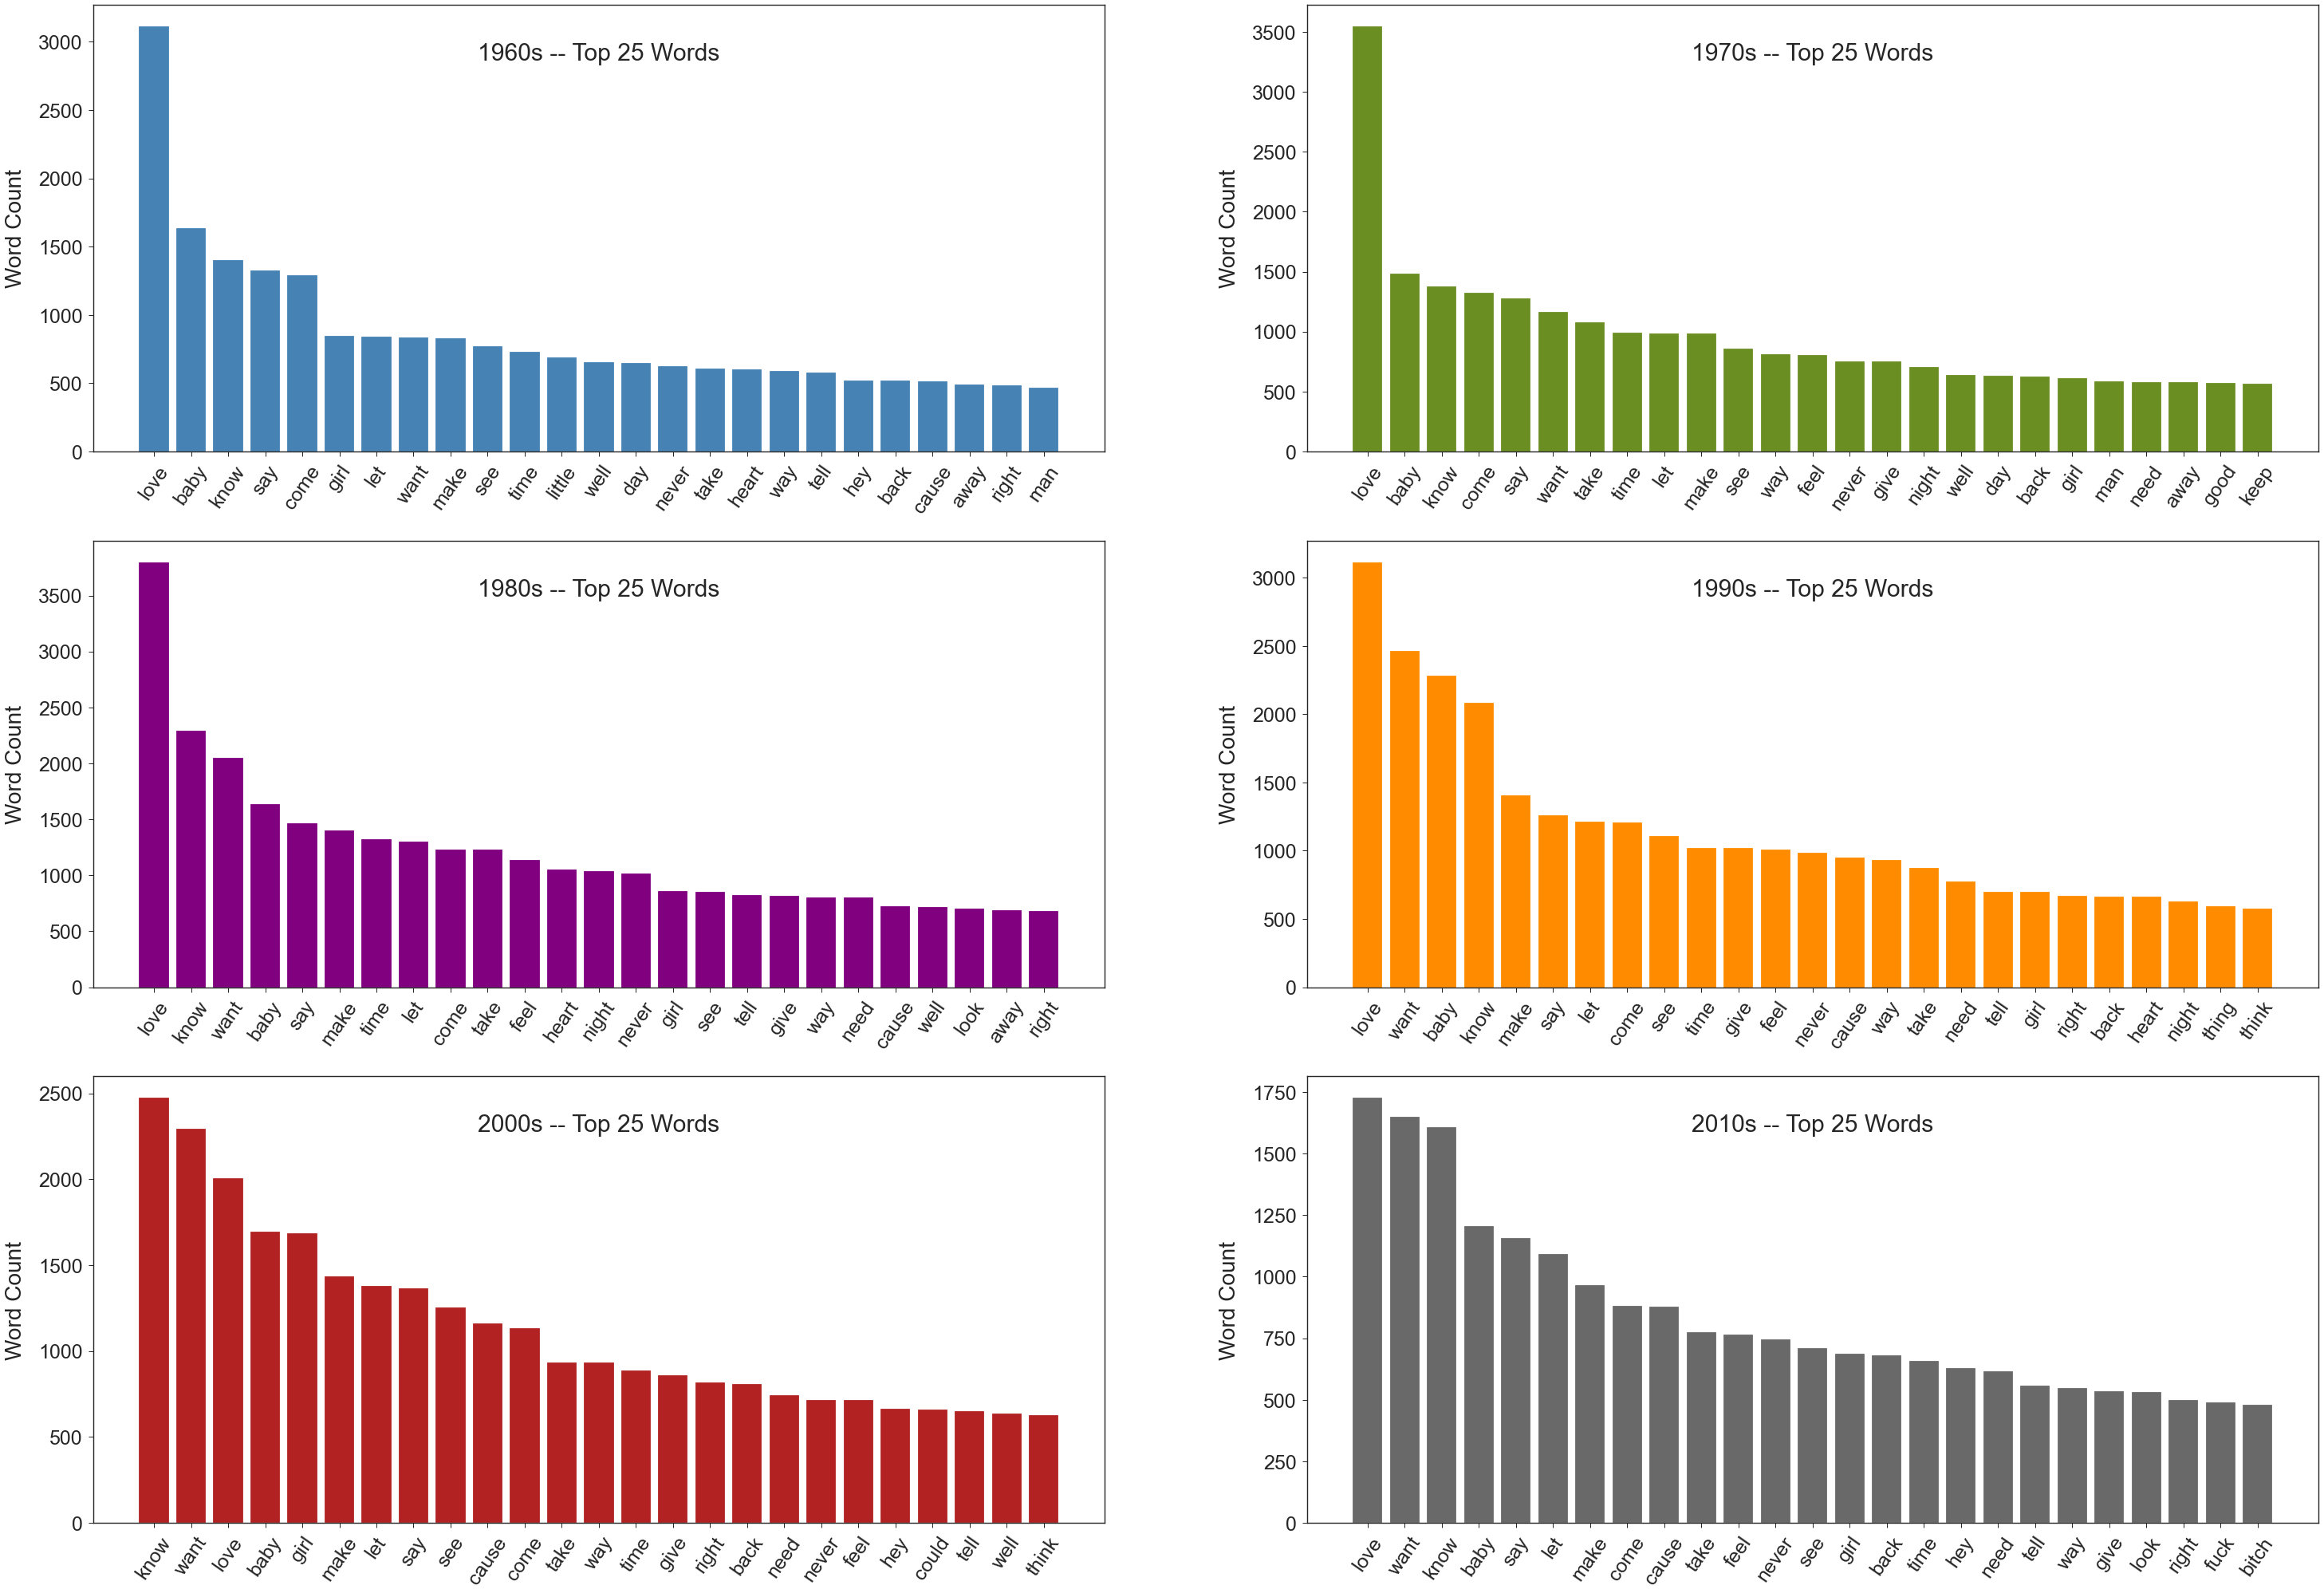

In [90]:
plt.figure(figsize=(50,35))

decades = list(df.decade.unique())

for i, decade in enumerate(decades):
    # create a series of processed poem strings
    decade_string_series = df[df.decade == decade].\
        lyrics_cleaned
    
    # convert the series to one big string
    decade_big_string = ' '.join(decade_string_series)
    
    # split the big string so I get all words in the decade
    decade_words = decade_big_string.split()
    
    # create dictionary of word counts
    fdist = FreqDist(decade_words)
    
    # convert word counts to dataframe
    fdist_df = pd.DataFrame(data=fdist.values(), 
                            index=fdist.keys(), 
                            columns=['word_count'])
    fdist_df = fdist_df.sort_values('word_count', 
                                    ascending=False)
    
    # look at the top 25 words for the movement
    top_25 = fdist_df.iloc[:25,:]

    # set dimension of plots
    nrows = 3
    ncols = 2

    # list of colors
    colors = ['steelblue', 'olivedrab', 'purple', 'darkorange', 'firebrick', 'dimgrey']
    
    # plot
    plt.subplot(nrows, ncols, i+1)
    plt.title(f'{decade} -- Top 25 Words', 
              fontsize=30, pad=15, x=0.5, y=0.85)
    plt.ylabel('Word Count', fontsize=28, labelpad=15)
    plt.xticks(rotation=55, fontsize=25)
    plt.yticks(fontsize=25)
    plt.bar(top_25.index, top_25.word_count, color=colors[i])
              
# # uncomment to save
# plt.savefig('charts/top25_words_decade_bar.png', 
#             bbox_inches='tight', transparent=True)

### Word cloud overall

[[go back to the top](#Song-Lyrics-Through-the-Years)]

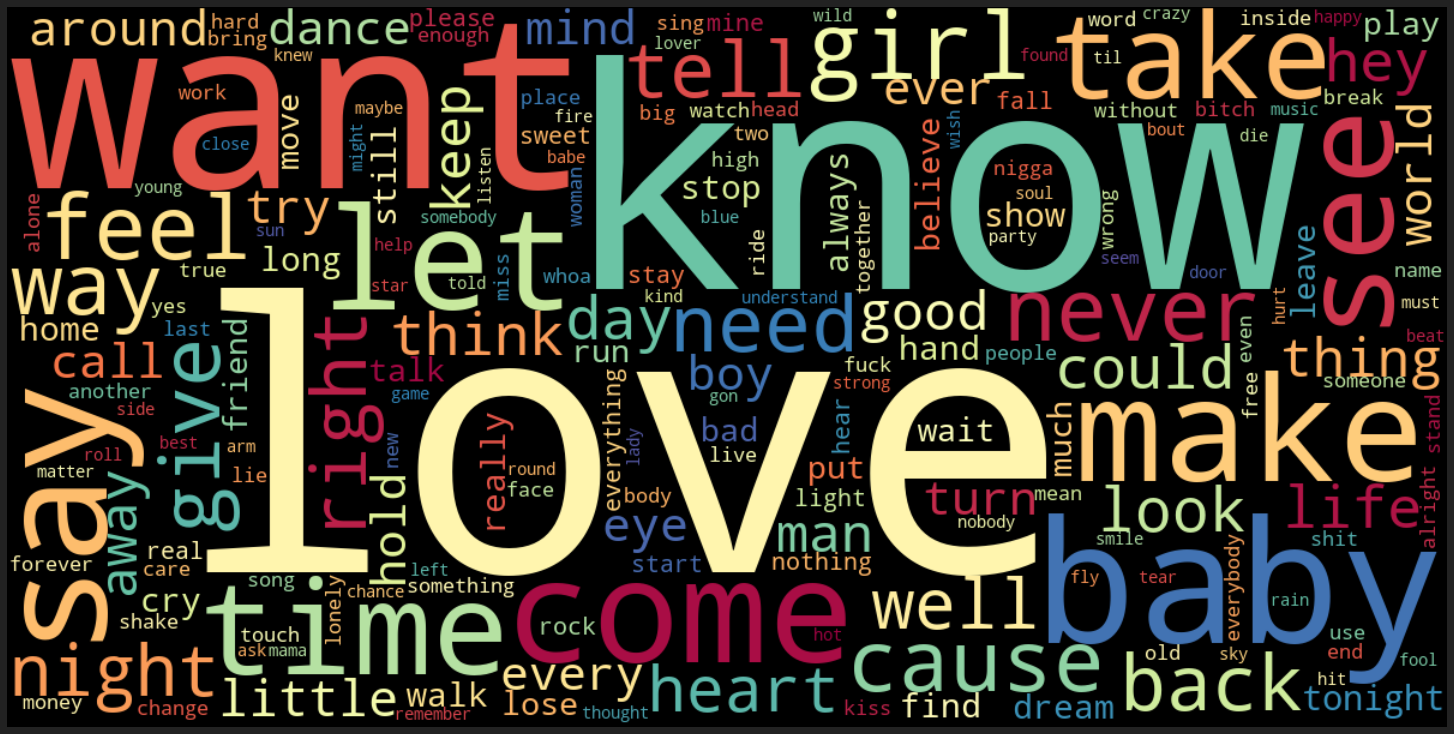

In [91]:
# create a dictionary for easy word cloud creation
word_dict = dict(Counter(all_words_proc))

# create word cloud
wordcloud = WordCloud(colormap='Spectral', 
                      width=1200, 
                      height=600).\
    generate_from_frequencies(word_dict)

# plot word cloud
plt.figure(figsize=(20,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)

# # uncomment to save
# plt.savefig('charts/word_cloud_overall.png', 
#             bbox_inches='tight', transparent=True)

### Word clouds by decade

[[go back to the top](#Song-Lyrics-Through-the-Years)]

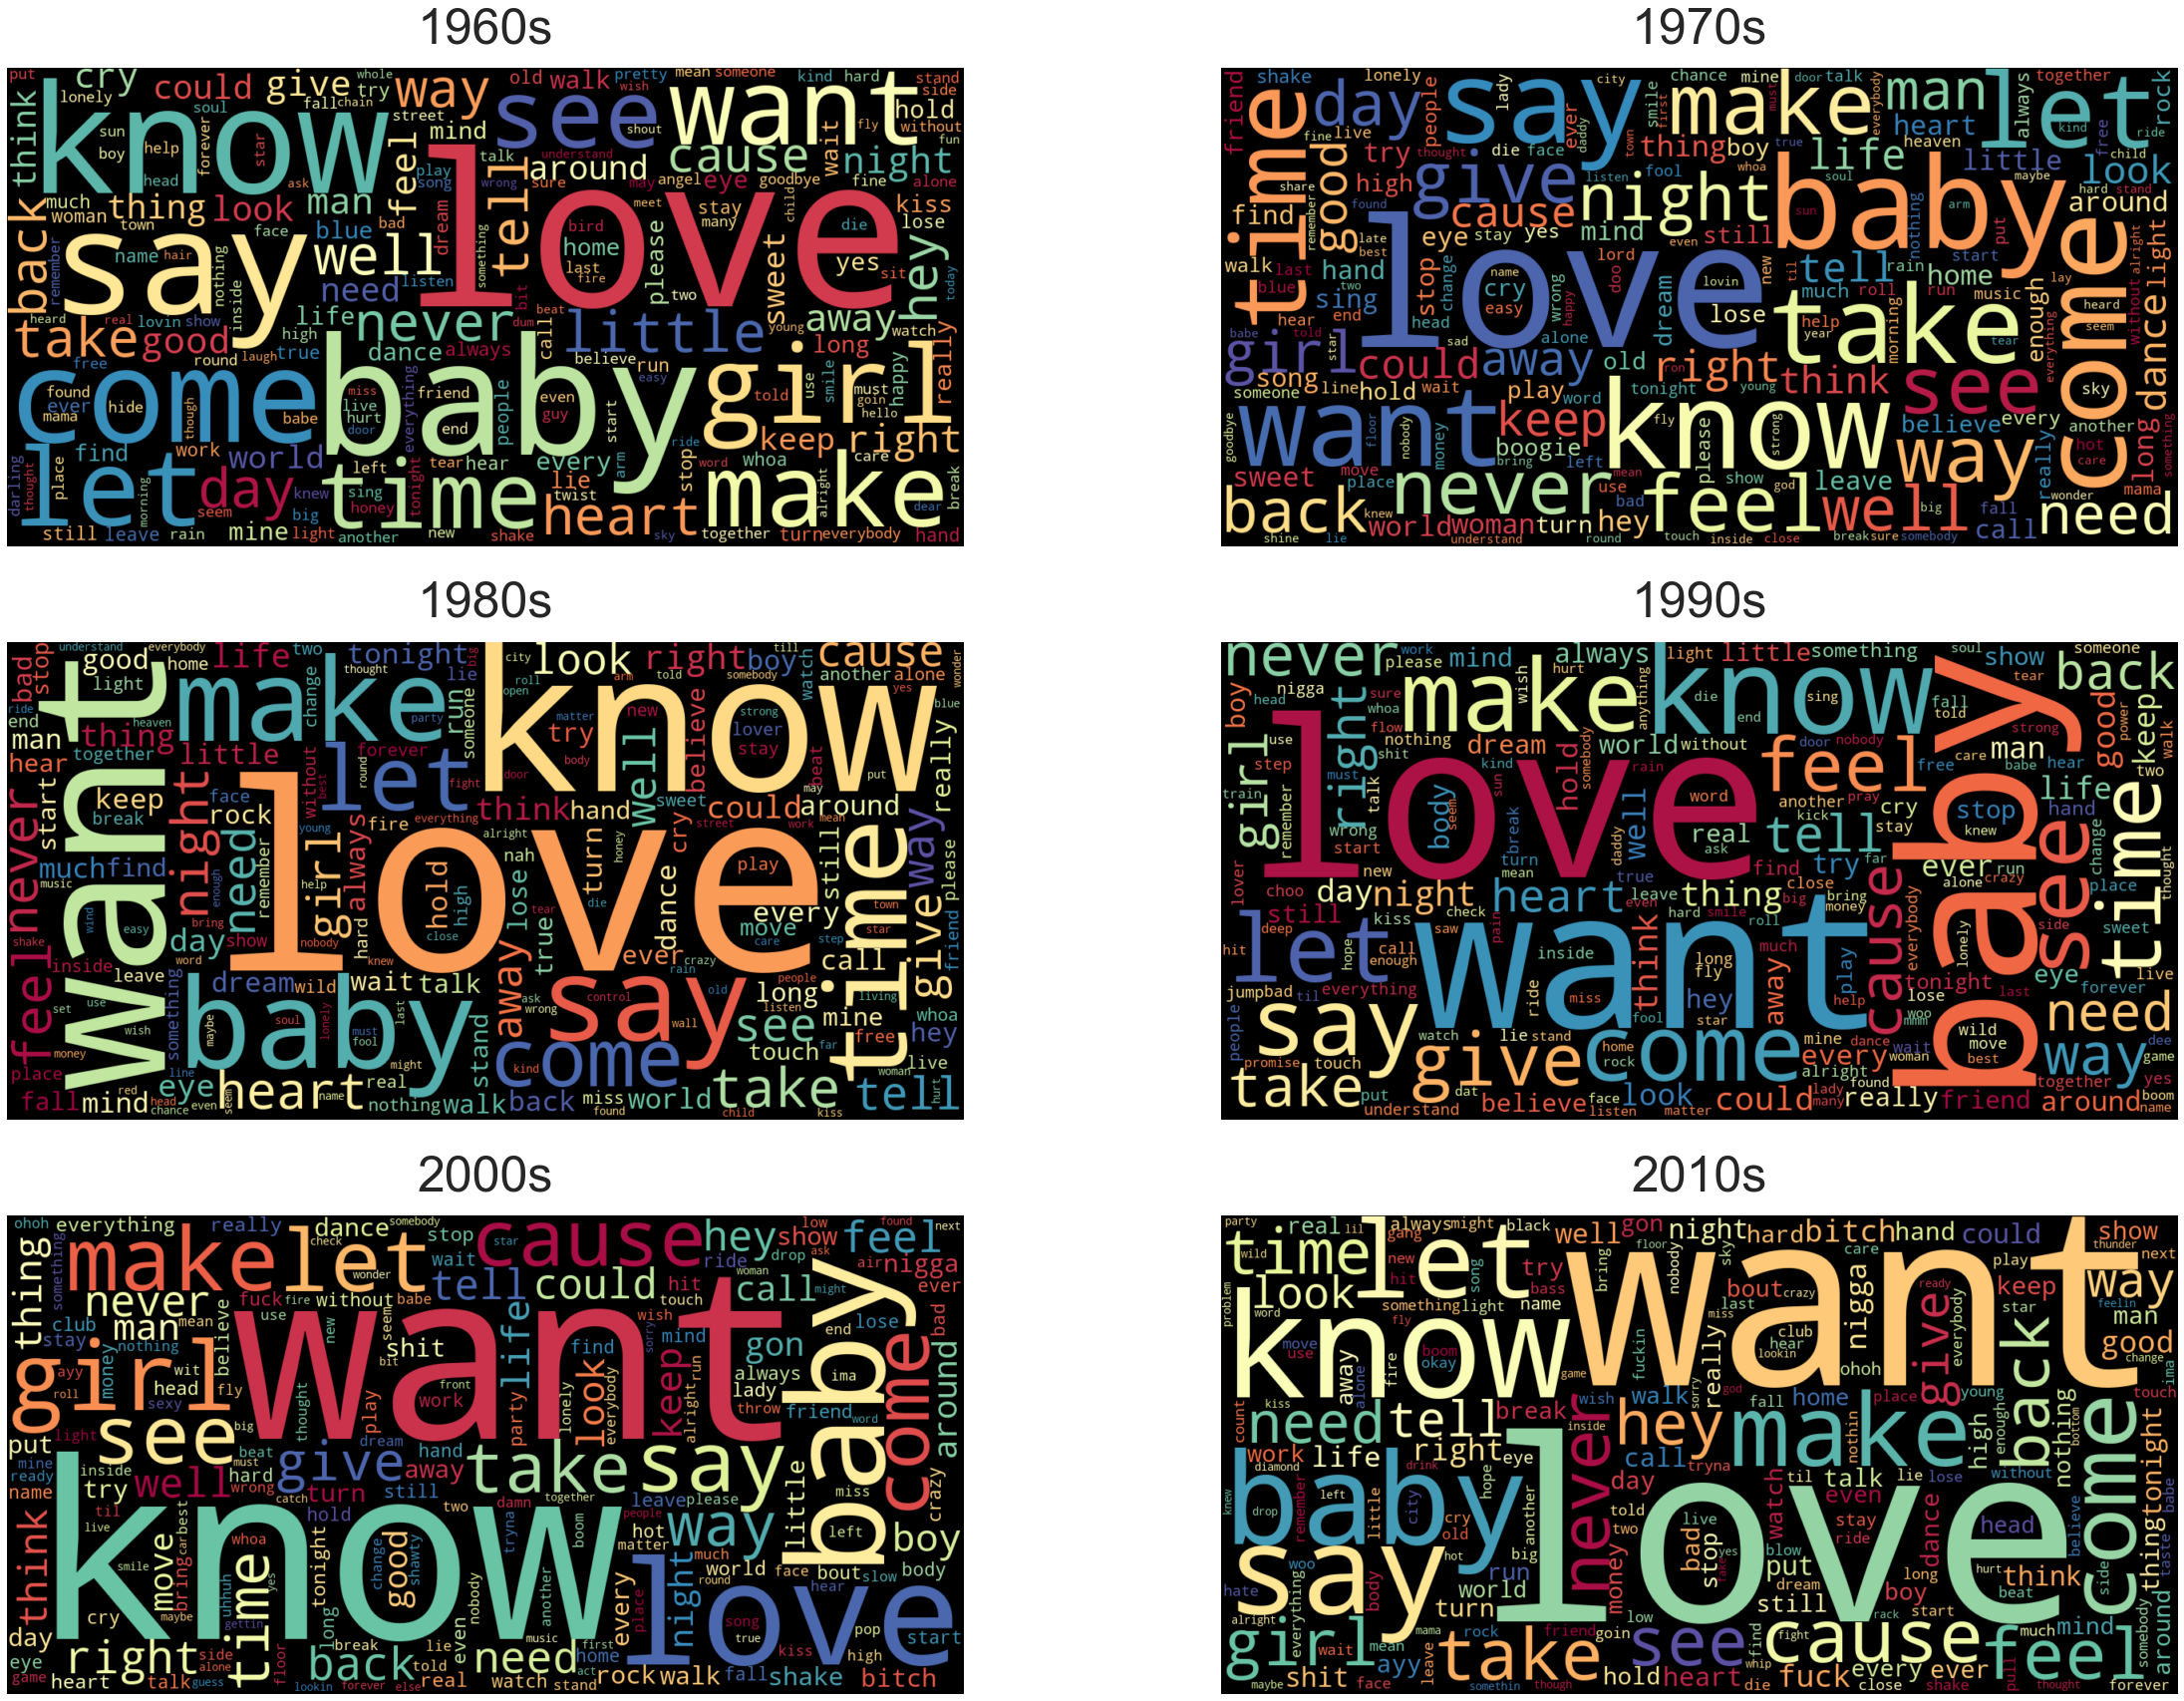

In [92]:
plt.figure(figsize=(40,30))

decades = list(df.decade.unique())

for i, decade in enumerate(decades):
    # create a series of processed poem strings
    decade_string_series = df[df.decade == decade].\
        lyrics_cleaned
    
    # convert the series to one big string
    decade_big_string = ' '.join(decade_string_series)
    
    # split the big string so i get all words in the decade
    decade_words = decade_big_string.split()
    
    # create a dictionary for easy word cloud creation
    decade_word_dict = dict(Counter(decade_words))

    # create word cloud
    decade_wordcloud = WordCloud(colormap='Spectral', 
                                   width=1200, 
                                   height=600).\
        generate_from_frequencies(decade_word_dict)

    nrows = 3
    ncols = 2

    plt.subplot(nrows, ncols, i+1)
    plt.plot()
    plt.imshow(decade_wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'{decade}', 
              fontsize=50, 
              pad=25)
              
# # uncomment to save
# plt.savefig('charts/word_cloud_decade.png', 
#             bbox_inches='tight', transparent=True)

In [93]:
df.columns

Index(['year', 'decade', 'title', 'artist', 'lyrics', 'lyrics_lined',
       'lyrics_no_artist', 'num_words', 'sentiment_polarity_score',
       'sentiment_polarity', 'sentiment_subjectivity_score', 'num_end_rhymes',
       'end_rhyme_ratio', 'end_rhyme', 'avg_syllables_word',
       'lexical_richness', 'lyrics_lower', 'self_reference', 'lyrics_cleaned'],
      dtype='object')

# Preliminary conclusions

[[go back to the top](#Song-Lyrics-Through-the-Years)]



## 💾 Save/Load DataFrame

[[go back to the top](#Song-Lyrics-Through-the-Years)]

In [94]:
# uncomment to save
with gzip.open('data/lyrics_df_all_features.pkl', 'wb') as goodbye:
    pickle.dump(df, goodbye, protocol=pickle.HIGHEST_PROTOCOL)
    
# # uncomment to load
# with gzip.open('data/lyrics_df_all_features.pkl', 'rb') as hello:
#     df = pickle.load(hello)

## Next notebook: [Modeling](04_modeling.ipynb)

[[go back to the top](#Song-Lyrics-Through-the-Years)]

- The next notebook includes classification modeling, a section with reproducible code for this project (including the work within this notebook), conclusions, and acknowledgements.